In [12]:
# import all packages used in this notebook
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.cm import tab10
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime

# add importable modules from src to system path for use in this notebook
import os
import sys
src_path = os.path.abspath(os.path.join(".."))
if src_path not in sys.path:
    sys.path.append(src_path)
import src

# Evaluate
Let's continue by evaluating our model forecasts in this notebook.

As before, we maintain alignment with the [`icenet-paper` repository](https://github.com/tom-andersson/icenet-paper).

### 1. Load forecasts, ground truth, and masks

We'll consider four forecasts in our evaluation against the OSI-SAF ground truth sea ice concentration data:
1. A linear trend baseline forecast, stored in `results/forecast_results/linear.nc`
2. A SEAS5 dynamical baseline, stored in `icenet-gan-data/forecasts/seas5/seas5_forecasts.nc`
3. A UNet forecast, from our best training [run](https://wandb.ai/andrewmcdonald/icenet-gan/runs/wq09bzy7/overview?workspace=user-andrewmcdonald) stored in `results/forecast_results/radiant-sponge-59-great-unet.nc`
3. A GAN forecast, from our best training [run](https://wandb.ai/andrewmcdonald/icenet-gan/runs/4iuiyi32/overview?workspace=user-andrewmcdonald) stored in `results/forecast_results/stilted-armadillo-99-great-gan.nc`

When considering deterministic forecast metrics, we'll use the mean forecast from our GAN ensemble.

We'll need to load in our active region masks to properly weight metrics in a spatial fashion as well.

In [2]:
linear_forecast = xr.open_dataarray(f"{src.config.forecast_results_folder}/linear.nc")
seas5_forecast = xr.open_dataarray(f"{src.config.forecast_data_folder}/seas5/seas5_forecasts.nc")
unet_forecast = xr.open_dataarray(f"{src.config.forecast_results_folder}/radiant-sponge-59-great-unet.nc")
gan_prob_forecast = xr.open_dataarray(f"{src.config.forecast_results_folder}/stilted-armadillo-99-great-gan.nc")
gan_forecast = gan_prob_forecast.sel(seed=["mean"])
true_forecast = xr.open_dataarray(f"{src.config.forecast_results_folder}/truth.nc")
forecast_mask = xr.open_dataarray(f"{src.config.forecast_results_folder}/mask.nc")


In [3]:
# filter seas5 forecast to test set dates, move leadtime to end, add ice_class dimension, add seed dimension
seas5_forecast = seas5_forecast.sel(time=linear_forecast.time)
seas5_forecast = seas5_forecast.transpose("time", "yc", "xc", "leadtime")
seas5_forecast = seas5_forecast.expand_dims("ice_class", -1)
seas5_forecast = seas5_forecast.expand_dims("seed", 0)
seas5_forecast

<xarray.DataArray (seed: 1, time: 17, yc: 432, xc: 432, leadtime: 6,
                   ice_class: 1)>
array([[[[[[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],
...
          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]],

          [[0.],
           [0.],
           [0.],
           [0.],
           [0.],
           [0.]]]]]])
Coordinates:
  * time      (time) datetime64[ns] 2018-02-01 2018-03-01 ... 2019-06-01
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * leadtime  (leadtime) int64 1 2 3 4 5 6
    lat       (yc, xc) float32 ...
    lon       (yc, xc) float32 ...
Dimensions without coordinates: seed, ice_class

In [4]:
# confirm that all shapes are (seed, dates, h, w, months, ice_class)
print(linear_forecast.shape)
print(seas5_forecast.shape)
print(unet_forecast.shape)
print(gan_forecast.shape)
print(true_forecast.shape)
print(forecast_mask.shape)

(1, 17, 432, 432, 6, 1)
(1, 17, 432, 432, 6, 1)
(1, 17, 432, 432, 6, 3)
(1, 17, 432, 432, 6, 3)
(1, 17, 432, 432, 6, 1)
(1, 17, 432, 432, 6, 1)


### 2. Compute binary accuracy
Binary accuracy, defined as the number of pixels correctly predicted as ice (SIC > 15%) and water (SIC < 15%), is the main metric used for evaluation in the original IceNet paper. Let's compute it here.

Throughout this notebook, we'll import functions from `src/evaluate.py` to abstract away implementation details and keep our focus on results.

In [36]:
binary_accuracies = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute binary accuracy for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    binary_accuracies["Leadtime"].append(leadtime)
    binary_accuracies["Linear"].append(src.binary_accuracy(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_accuracies["SEAS5"].append(src.binary_accuracy(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_accuracies["UNet"].append(src.binary_accuracy(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_accuracies["GAN"].append(src.binary_accuracy(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute binary accuracy for all leadtimes
binary_accuracies["Leadtime"].append("All")
leads = list(range(1, 7))
binary_accuracies["Linear"].append(src.binary_accuracy(linear_forecast, true_forecast, forecast_mask, leads))
binary_accuracies["SEAS5"].append(src.binary_accuracy(seas5_forecast, true_forecast, forecast_mask, leads))
binary_accuracies["UNet"].append(src.binary_accuracy(unet_forecast, true_forecast, forecast_mask, leads))
binary_accuracies["GAN"].append(src.binary_accuracy(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
binary_accuracies_df = pd.DataFrame(binary_accuracies).set_index("Leadtime")
binary_accuracies_df

100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Linear     SEAS5      UNet       GAN
Leadtime                                        
1         0.887100  0.900908  0.855447  0.855698
2         0.876941  0.811257  0.805966  0.805090
3         0.874033  0.754157  0.757892  0.755051
4         0.873323  0.724212  0.725470  0.721581
5         0.872397  0.714133  0.779266  0.779486
6         0.874576  0.720008  0.813152  0.815744
All       0.876531  0.772724  0.790467  0.789719

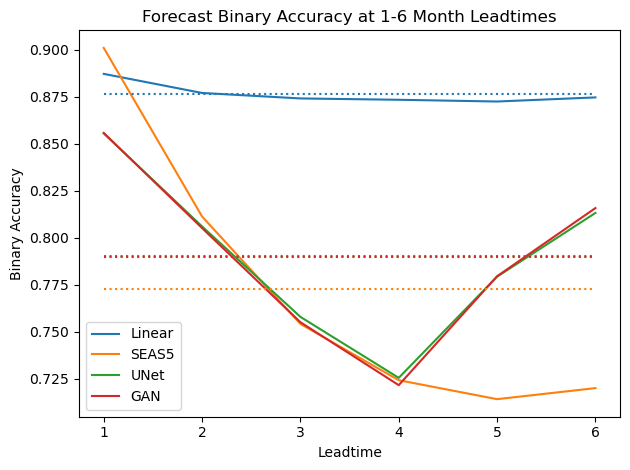

In [46]:
# plot against leadtime
fig, ax = plt.subplots()
binary_accuracies_df.drop("All").plot(ax=ax)
for i, model in enumerate(binary_accuracies_df.columns):
    plt.hlines(binary_accuracies_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("Binary Accuracy")
plt.title("Forecast Binary Accuracy at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### 3. Compute binary F1
Accuracy is a useful metric, but it doesn't tell us the whole story when dealing with imbalanced data! 

Let's have a look at binary F1.

In [6]:
binary_f1s = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute binary f1 for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    binary_f1s["Leadtime"].append(leadtime)
    binary_f1s["Linear"].append(src.binary_f1(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_f1s["SEAS5"].append(src.binary_f1(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_f1s["UNet"].append(src.binary_f1(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    binary_f1s["GAN"].append(src.binary_f1(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute binary f1 for all leadtimes
binary_f1s["Leadtime"].append("All")
leads = list(range(1, 7))
binary_f1s["Linear"].append(src.binary_f1(linear_forecast, true_forecast, forecast_mask, leads))
binary_f1s["SEAS5"].append(src.binary_f1(seas5_forecast, true_forecast, forecast_mask, leads))
binary_f1s["UNet"].append(src.binary_f1(unet_forecast, true_forecast, forecast_mask, leads))
binary_f1s["GAN"].append(src.binary_f1(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
binary_f1s_df = pd.DataFrame(binary_f1s).set_index("Leadtime")
binary_f1s_df

100%|██████████| 6/6 [01:00<00:00, 10.11s/it]


Linear     SEAS5      UNet       GAN
Leadtime                                        
1         0.914212  0.924311  0.887384  0.887579
2         0.905322  0.857623  0.846271  0.844814
3         0.901313  0.813445  0.803332  0.800753
4         0.898731  0.788448  0.773918  0.769104
5         0.896540  0.778385  0.815352  0.815008
6         0.897447  0.781428  0.845164  0.847240
All       0.902588  0.825816  0.830079  0.829007

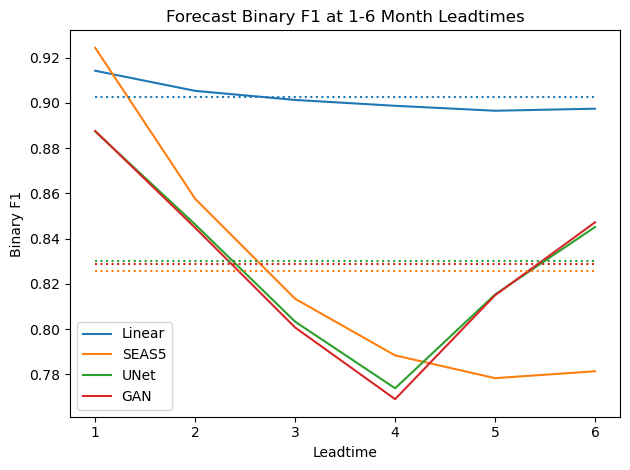

In [7]:
# plot against leadtime
fig, ax = plt.subplots()
binary_f1s_df.drop("All").plot(ax=ax)
for i, model in enumerate(binary_f1s_df.columns):
    plt.hlines(binary_f1s_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("Binary F1")
plt.title("Forecast Binary F1 at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### 4. Compute ternary accuracy
Although binary accuracy is the metric of greatest interest in the original IceNet paper, we choose to investigate ternary accuracy as our UNet and GAN models are trained on three-class data.

Recall that this data comprises `SIC < 15%` (ice-free), `15% ≤ SIC ≤ 85%` (marginal ice), and `SIC > 85%` (full ice).

In [38]:
ternary_accuracies = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute ternary accuracy for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    ternary_accuracies["Leadtime"].append(leadtime)
    ternary_accuracies["Linear"].append(src.ternary_accuracy(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_accuracies["SEAS5"].append(src.ternary_accuracy(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_accuracies["UNet"].append(src.ternary_accuracy(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_accuracies["GAN"].append(src.ternary_accuracy(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute ternary accuracy for all leadtimes
ternary_accuracies["Leadtime"].append("All")
leads = list(range(1, 7))
ternary_accuracies["Linear"].append(src.ternary_accuracy(linear_forecast, true_forecast, forecast_mask, leads))
ternary_accuracies["SEAS5"].append(src.ternary_accuracy(seas5_forecast, true_forecast, forecast_mask, leads))
ternary_accuracies["UNet"].append(src.ternary_accuracy(unet_forecast, true_forecast, forecast_mask, leads))
ternary_accuracies["GAN"].append(src.ternary_accuracy(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
ternary_accuracies_df = pd.DataFrame(ternary_accuracies).set_index("Leadtime")
ternary_accuracies_df

100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


Linear     SEAS5      UNet       GAN
Leadtime                                        
1         0.777852  0.778360  0.696818  0.692776
2         0.764714  0.638466  0.626656  0.622218
3         0.757635  0.553836  0.564635  0.556565
4         0.752015  0.501756  0.558225  0.553782
5         0.747653  0.479981  0.638901  0.637253
6         0.752954  0.498333  0.666295  0.671265
All       0.759097  0.578185  0.626044  0.623066

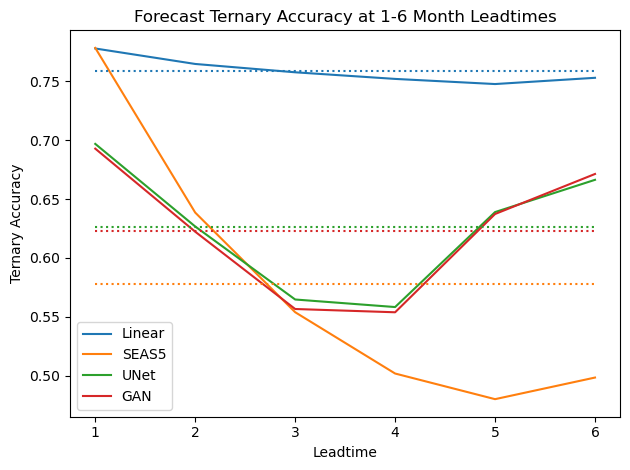

In [47]:
# plot against leadtime
fig, ax = plt.subplots()
ternary_accuracies_df.drop("All").plot(ax=ax)
for i, model in enumerate(ternary_accuracies_df.columns):
    plt.hlines(ternary_accuracies_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("Ternary Accuracy")
plt.title("Forecast Ternary Accuracy at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### 5. Compute ternary F1
Again, given the fact that we trained our UNet and GAN on three-class data, it would not be fair to forego a ternary F1 evaluation.

We'll consider the macro-averaged F1, as macro-averaged metrics give more weight to underrepresented classes.

In [8]:
ternary_f1s = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute ternary f1 for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    ternary_f1s["Leadtime"].append(leadtime)
    ternary_f1s["Linear"].append(src.ternary_f1(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_f1s["SEAS5"].append(src.ternary_f1(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_f1s["UNet"].append(src.ternary_f1(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    ternary_f1s["GAN"].append(src.ternary_f1(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute ternary f1 for all leadtimes
ternary_f1s["Leadtime"].append("All")
leads = list(range(1, 7))
ternary_f1s["Linear"].append(src.ternary_f1(linear_forecast, true_forecast, forecast_mask, leads))
ternary_f1s["SEAS5"].append(src.ternary_f1(seas5_forecast, true_forecast, forecast_mask, leads))
ternary_f1s["UNet"].append(src.ternary_f1(unet_forecast, true_forecast, forecast_mask, leads))
ternary_f1s["GAN"].append(src.ternary_f1(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
ternary_f1s_df = pd.DataFrame(ternary_f1s).set_index("Leadtime")
ternary_f1s_df

100%|██████████| 6/6 [00:48<00:00,  8.17s/it]


Linear     SEAS5      UNet       GAN
Leadtime                                        
1         0.742061  0.733912  0.631526  0.624656
2         0.734225  0.593762  0.568506  0.562564
3         0.731362  0.512734  0.516935  0.512052
4         0.728084  0.465879  0.514555  0.510976
5         0.722490  0.444989  0.589866  0.589380
6         0.721203  0.459809  0.604774  0.613636
All       0.730483  0.537842  0.571725  0.569608

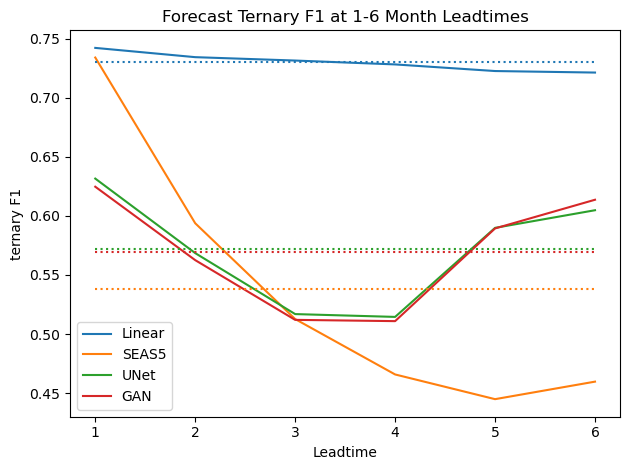

In [9]:
# plot against leadtime
fig, ax = plt.subplots()
ternary_f1s_df.drop("All").plot(ax=ax)
for i, model in enumerate(ternary_f1s_df.columns):
    plt.hlines(ternary_f1s_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("ternary F1")
plt.title("Forecast Ternary F1 at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### 5. Compute SIE error
Next, we'll compute SIE error. This characterises the overall spatial bias of each forecast in a binary sense, measuring the overshoot/undershoot of `SIC > 15%` for a given set of leadtimes.

In [4]:
sie_errors = {"Leadtime": [], "Linear": [], "SEAS5": [], "UNet": [], "GAN": []}

# compute binary f1 for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    sie_errors["Leadtime"].append(leadtime)
    sie_errors["Linear"].append(src.sie_error(linear_forecast, true_forecast, forecast_mask, [leadtime]))
    sie_errors["SEAS5"].append(src.sie_error(seas5_forecast, true_forecast, forecast_mask, [leadtime]))
    sie_errors["UNet"].append(src.sie_error(unet_forecast, true_forecast, forecast_mask, [leadtime]))
    sie_errors["GAN"].append(src.sie_error(gan_forecast, true_forecast, forecast_mask, [leadtime]))

# compute binary f1 for all leadtimes
sie_errors["Leadtime"].append("All")
leads = list(range(1, 7))
sie_errors["Linear"].append(src.sie_error(linear_forecast, true_forecast, forecast_mask, leads))
sie_errors["SEAS5"].append(src.sie_error(seas5_forecast, true_forecast, forecast_mask, leads))
sie_errors["UNet"].append(src.sie_error(unet_forecast, true_forecast, forecast_mask, leads))
sie_errors["GAN"].append(src.sie_error(gan_forecast, true_forecast, forecast_mask, leads))

# construct dataframe
sie_errors_df = pd.DataFrame(sie_errors).set_index("Leadtime")
sie_errors_df

100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Linear         SEAS5           UNet            GAN
Leadtime                                                           
1         663566.176471  5.426103e+05   88125.000000   88014.705882
2         839411.764706  1.287279e+06  189705.882353   82500.000000
3         838125.000000  1.532022e+06   76801.470588   48713.235294
4         649154.411765  1.515000e+06   48088.235294  -90992.647059
5         421691.176471  1.346875e+06 -198492.647059 -254301.470588
6         150992.647059  1.112243e+06 -118713.235294 -128161.764706
All       593823.529412  1.222672e+06   14252.450980  -42371.323529

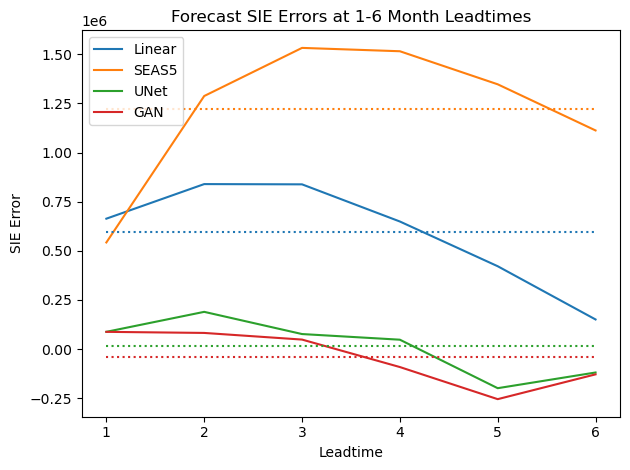

In [5]:
# plot against leadtime
fig, ax = plt.subplots()
sie_errors_df.drop("All").plot(ax=ax)
for i, model in enumerate(sie_errors_df.columns):
    plt.hlines(sie_errors_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i), linestyles=":")
plt.ylabel("SIE Error")
plt.title("Forecast SIE Errors at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### n. Visualise a summer forecast
To characterise our model forecasts in a more holistic sense, we'll plot the output of a select few full six-month forecasts.

Given that we've trained on ternary data, we'll visualise the forecasts in three-class form.

In particular, we'll plot out a summer forecast (predicting forward from April after the annual maximum occurs in March).

In [87]:
forecast_dict = {
    "Linear": linear_forecast,
    "SEAS5": seas5_forecast,
    "UNet": unet_forecast,
    "GAN": gan_forecast,
}
forecast_dict_with_truth = forecast_dict.copy()
forecast_dict_with_truth["True"] = true_forecast

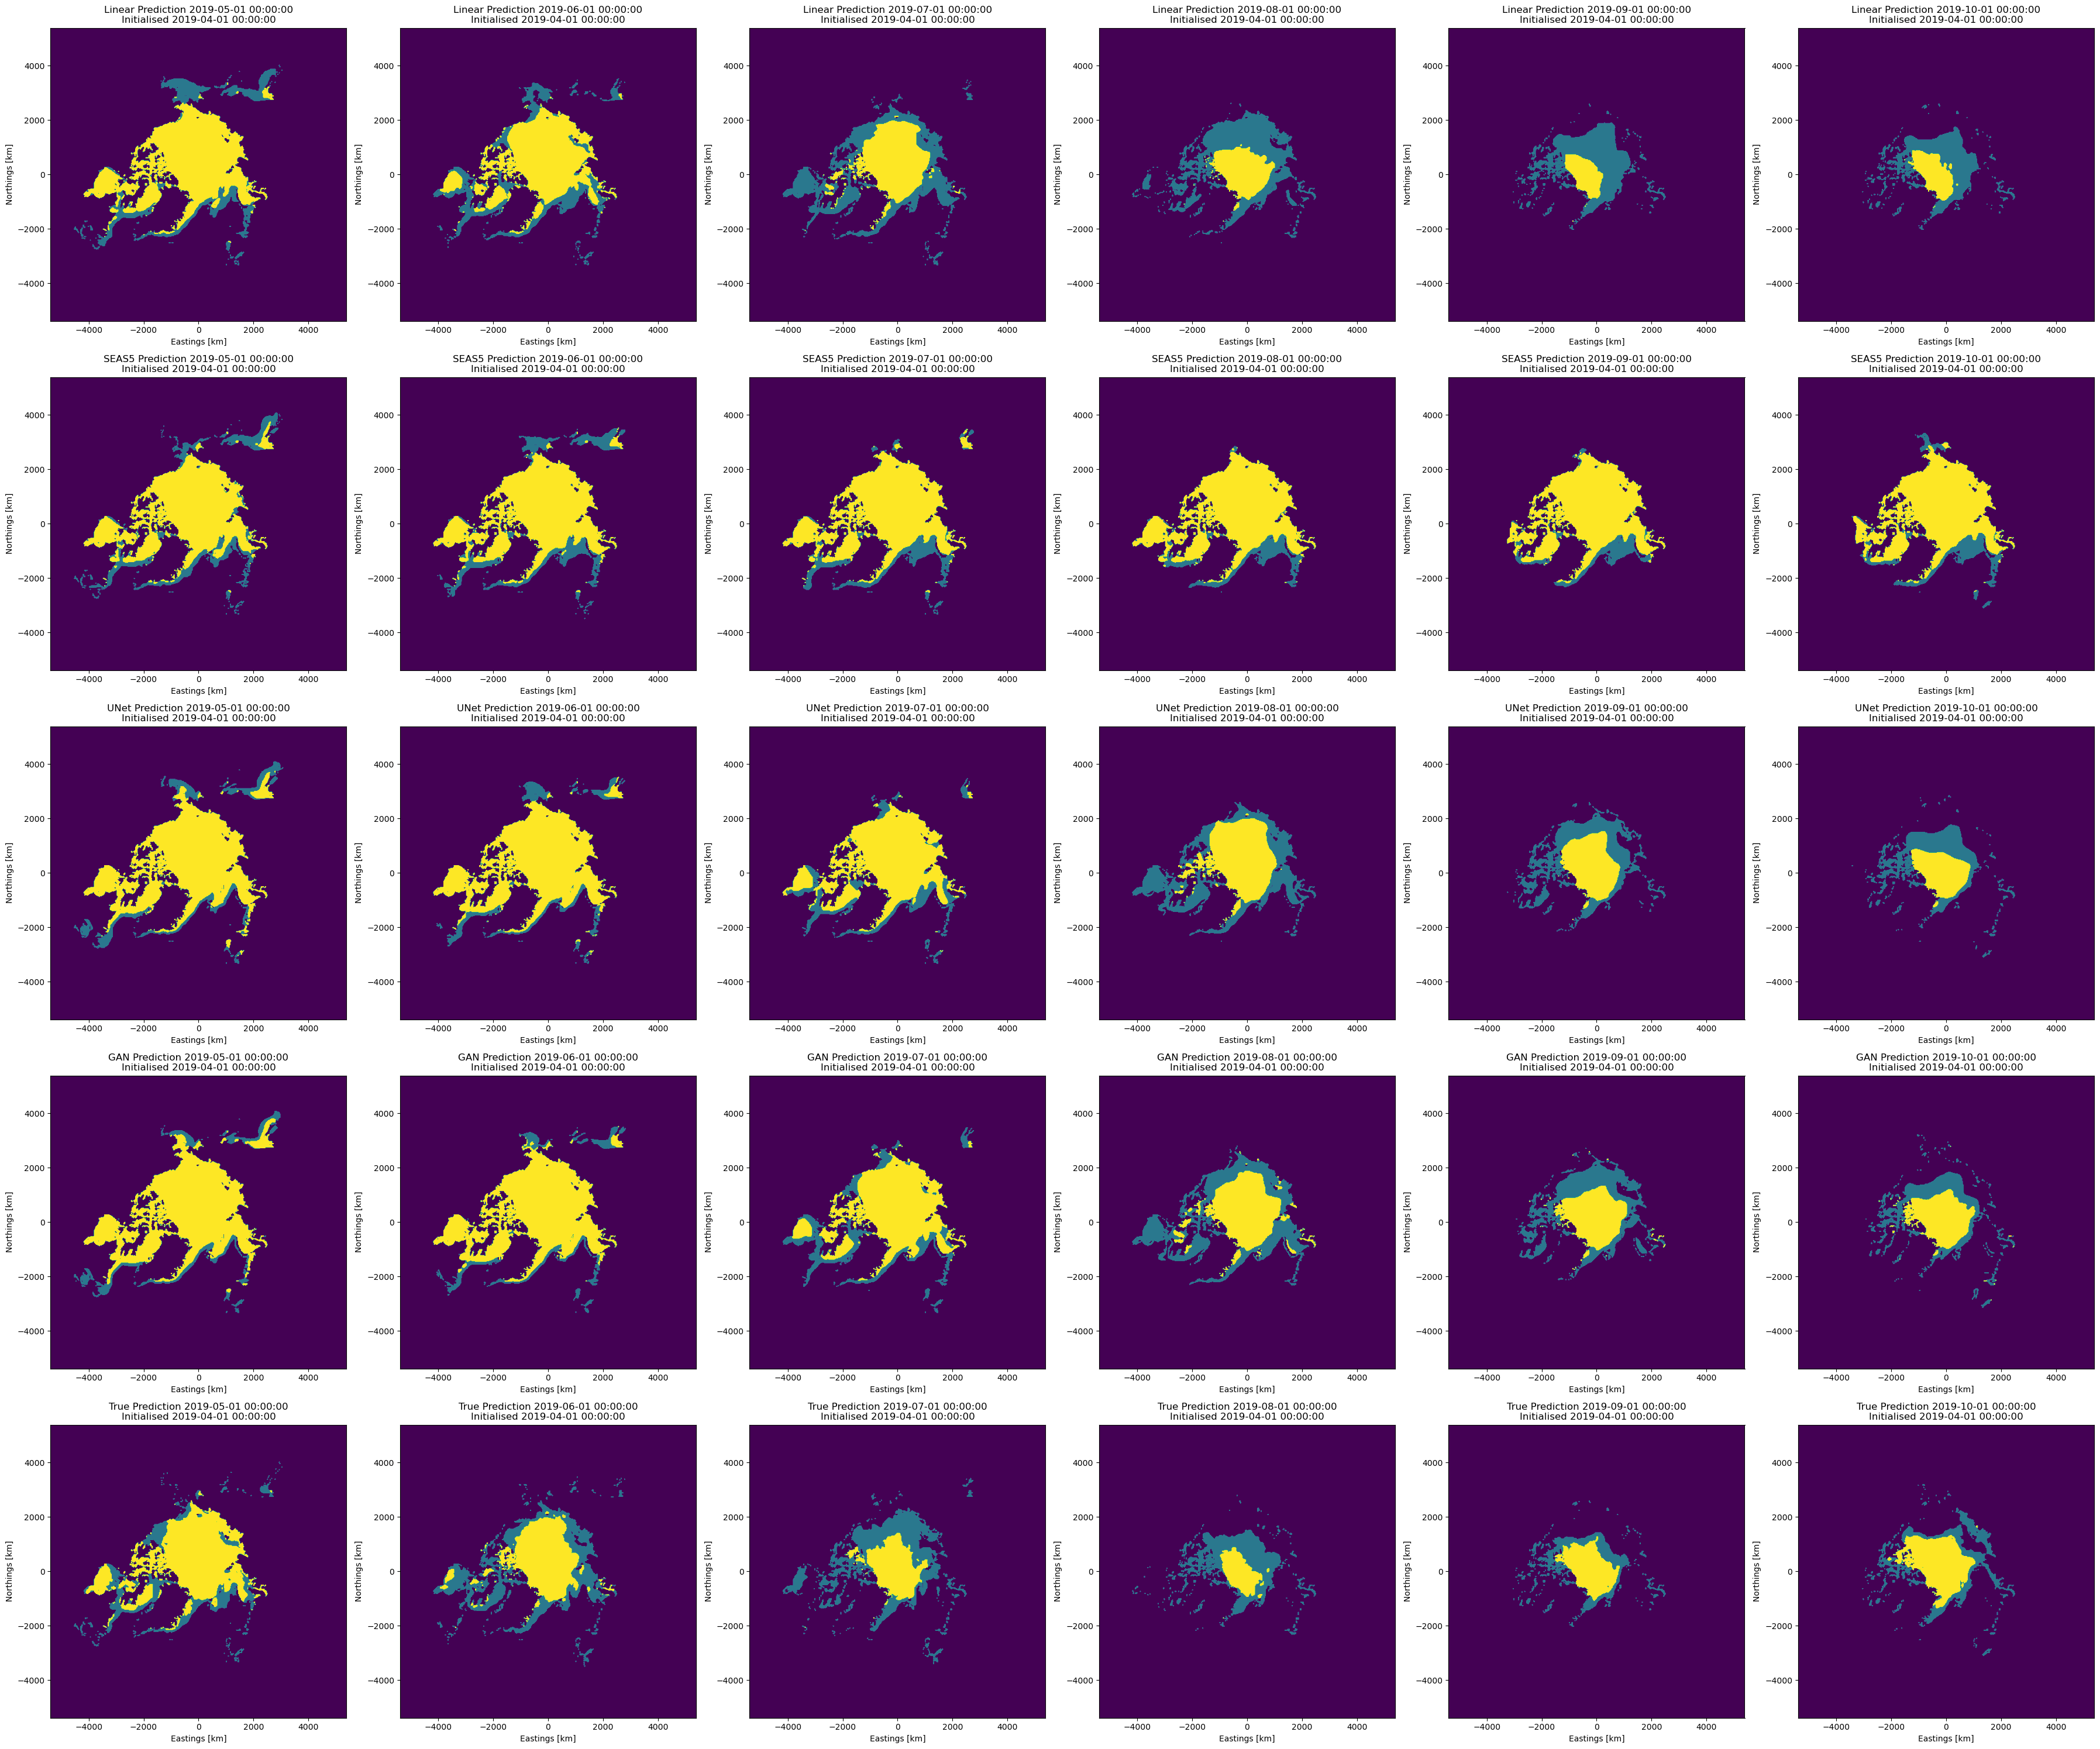

In [88]:
summer = datetime(year=2019, month=4, day=1)
src.visualise_forecast(forecast_dict_with_truth, forecast_mask, summer)

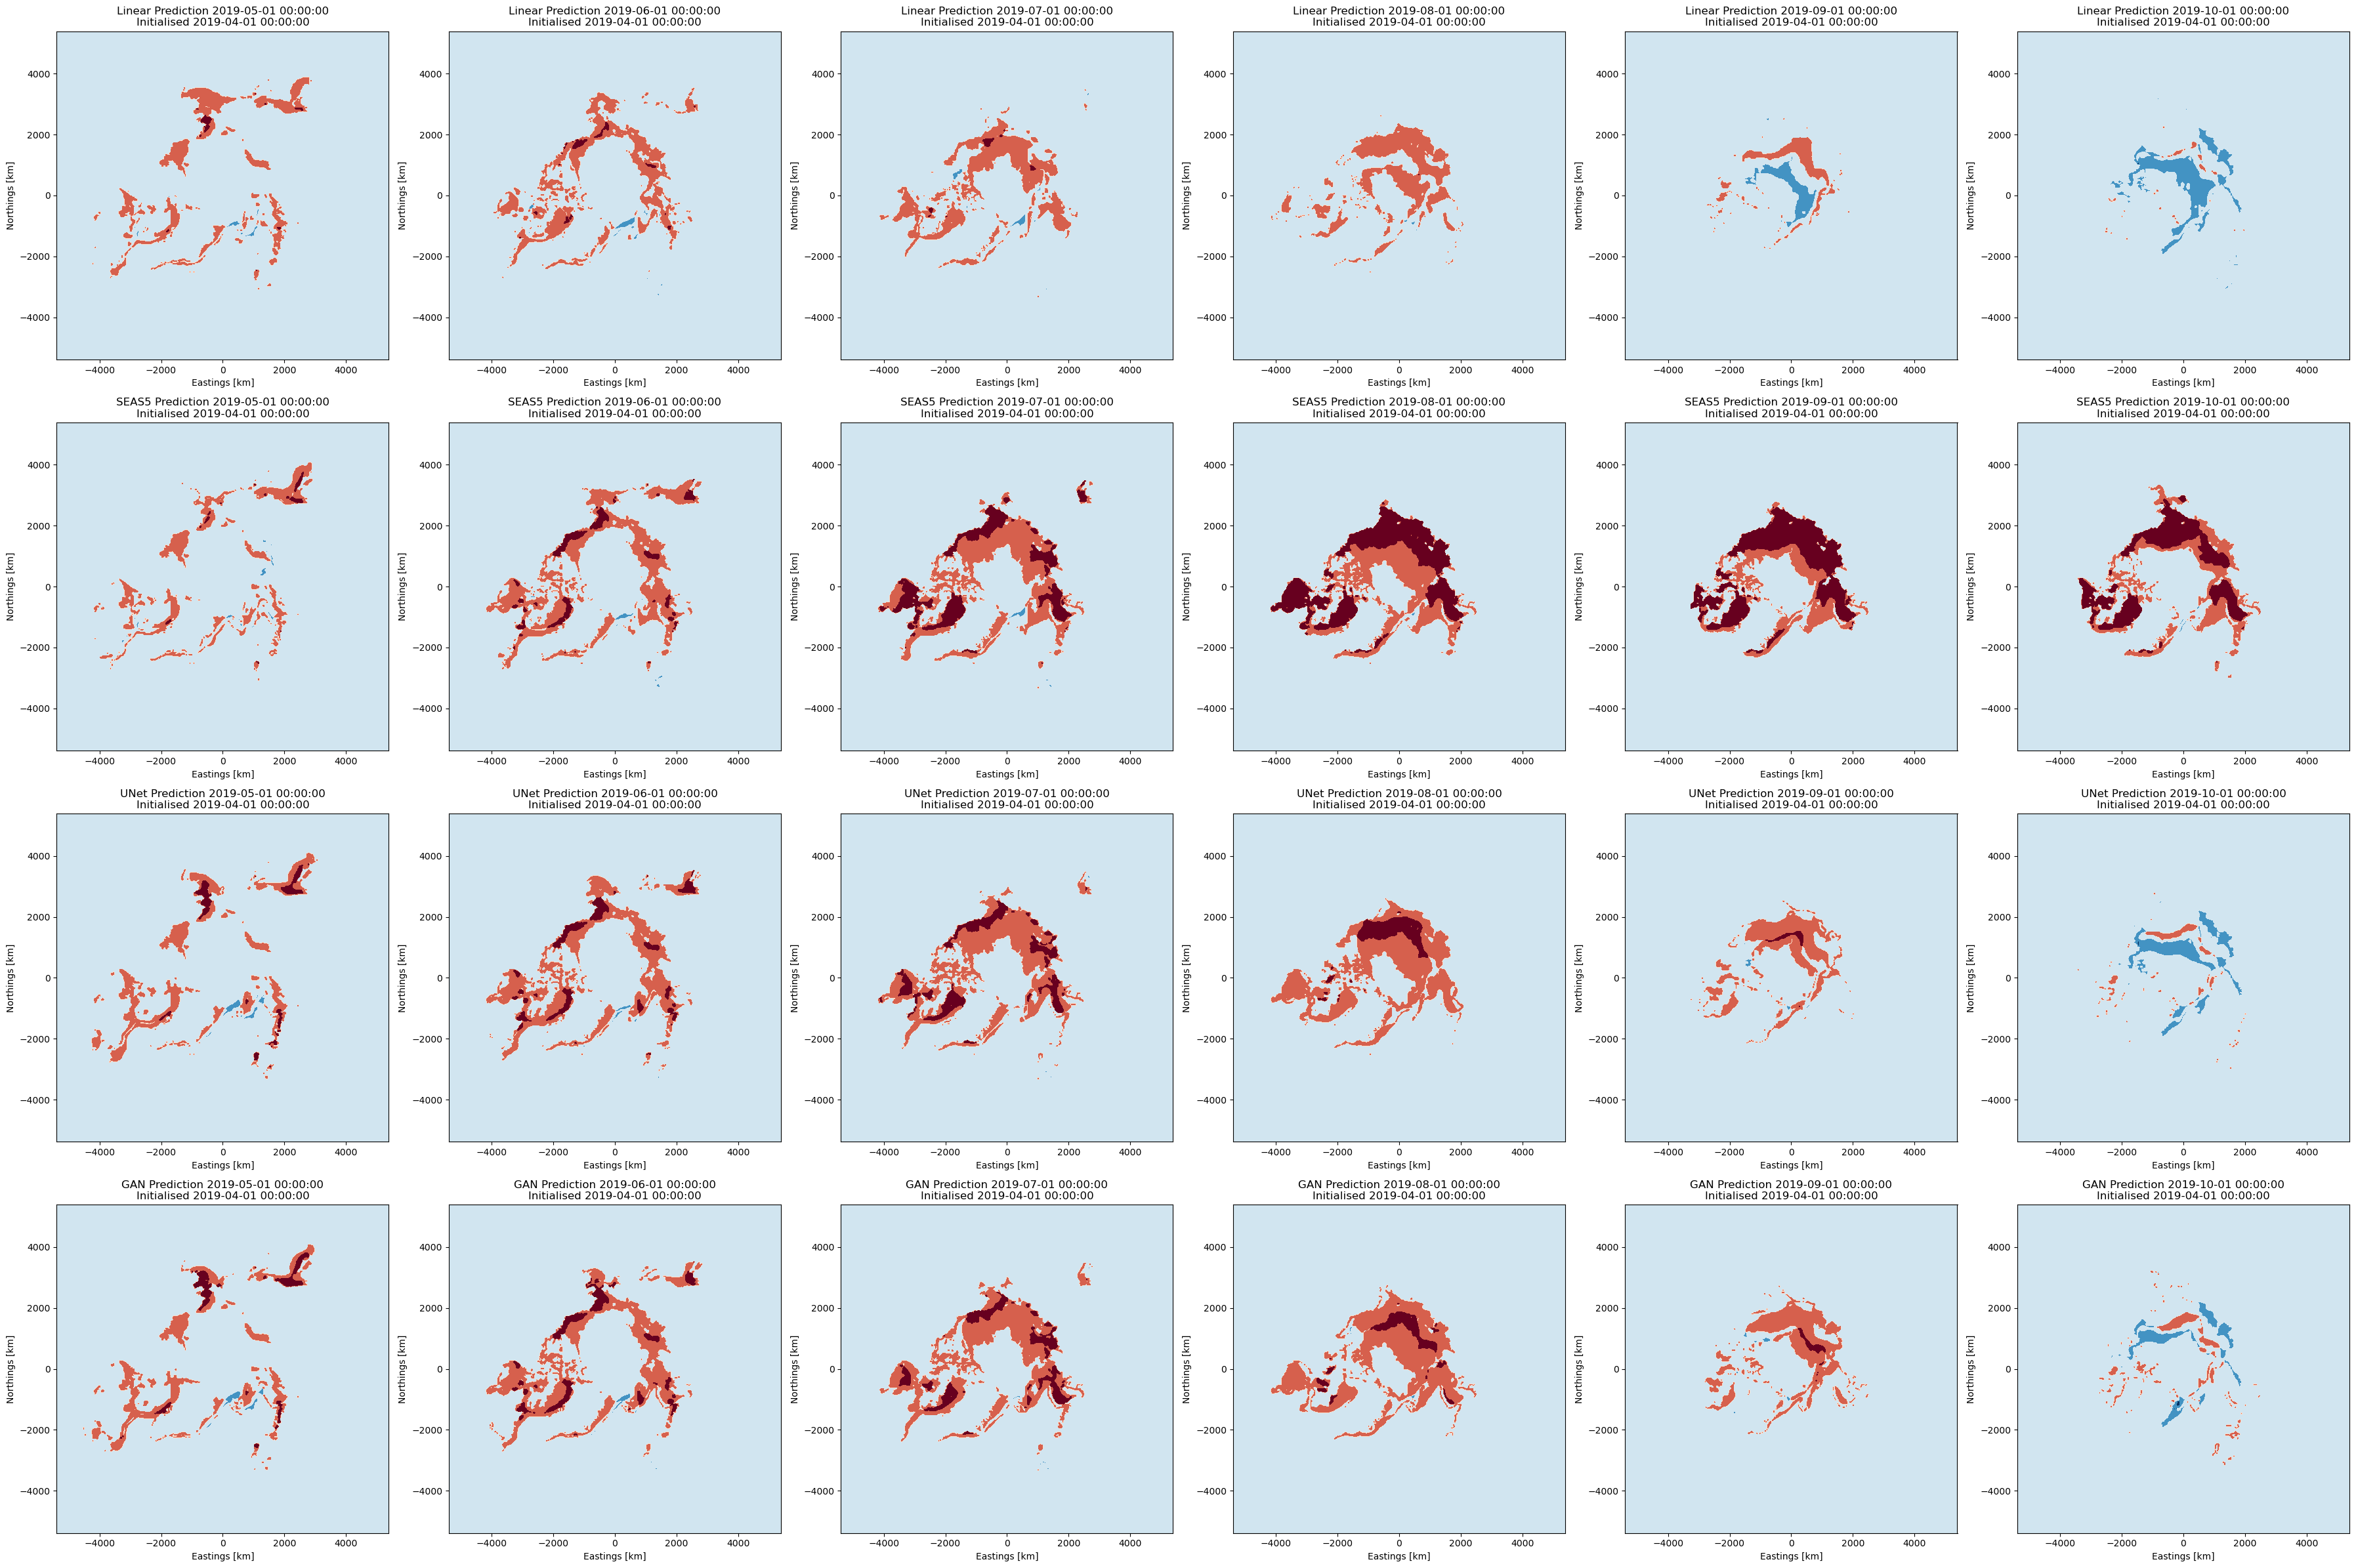

In [89]:
src.visualise_forecast(forecast_dict, forecast_mask, summer, diff=True, true_forecast=true_forecast)

### n. Visualise a winter forecast
Continuing the theme from the previous section, we'll plot an individual winter forecast (predicting forward from October after the annual minimum occurs in September).

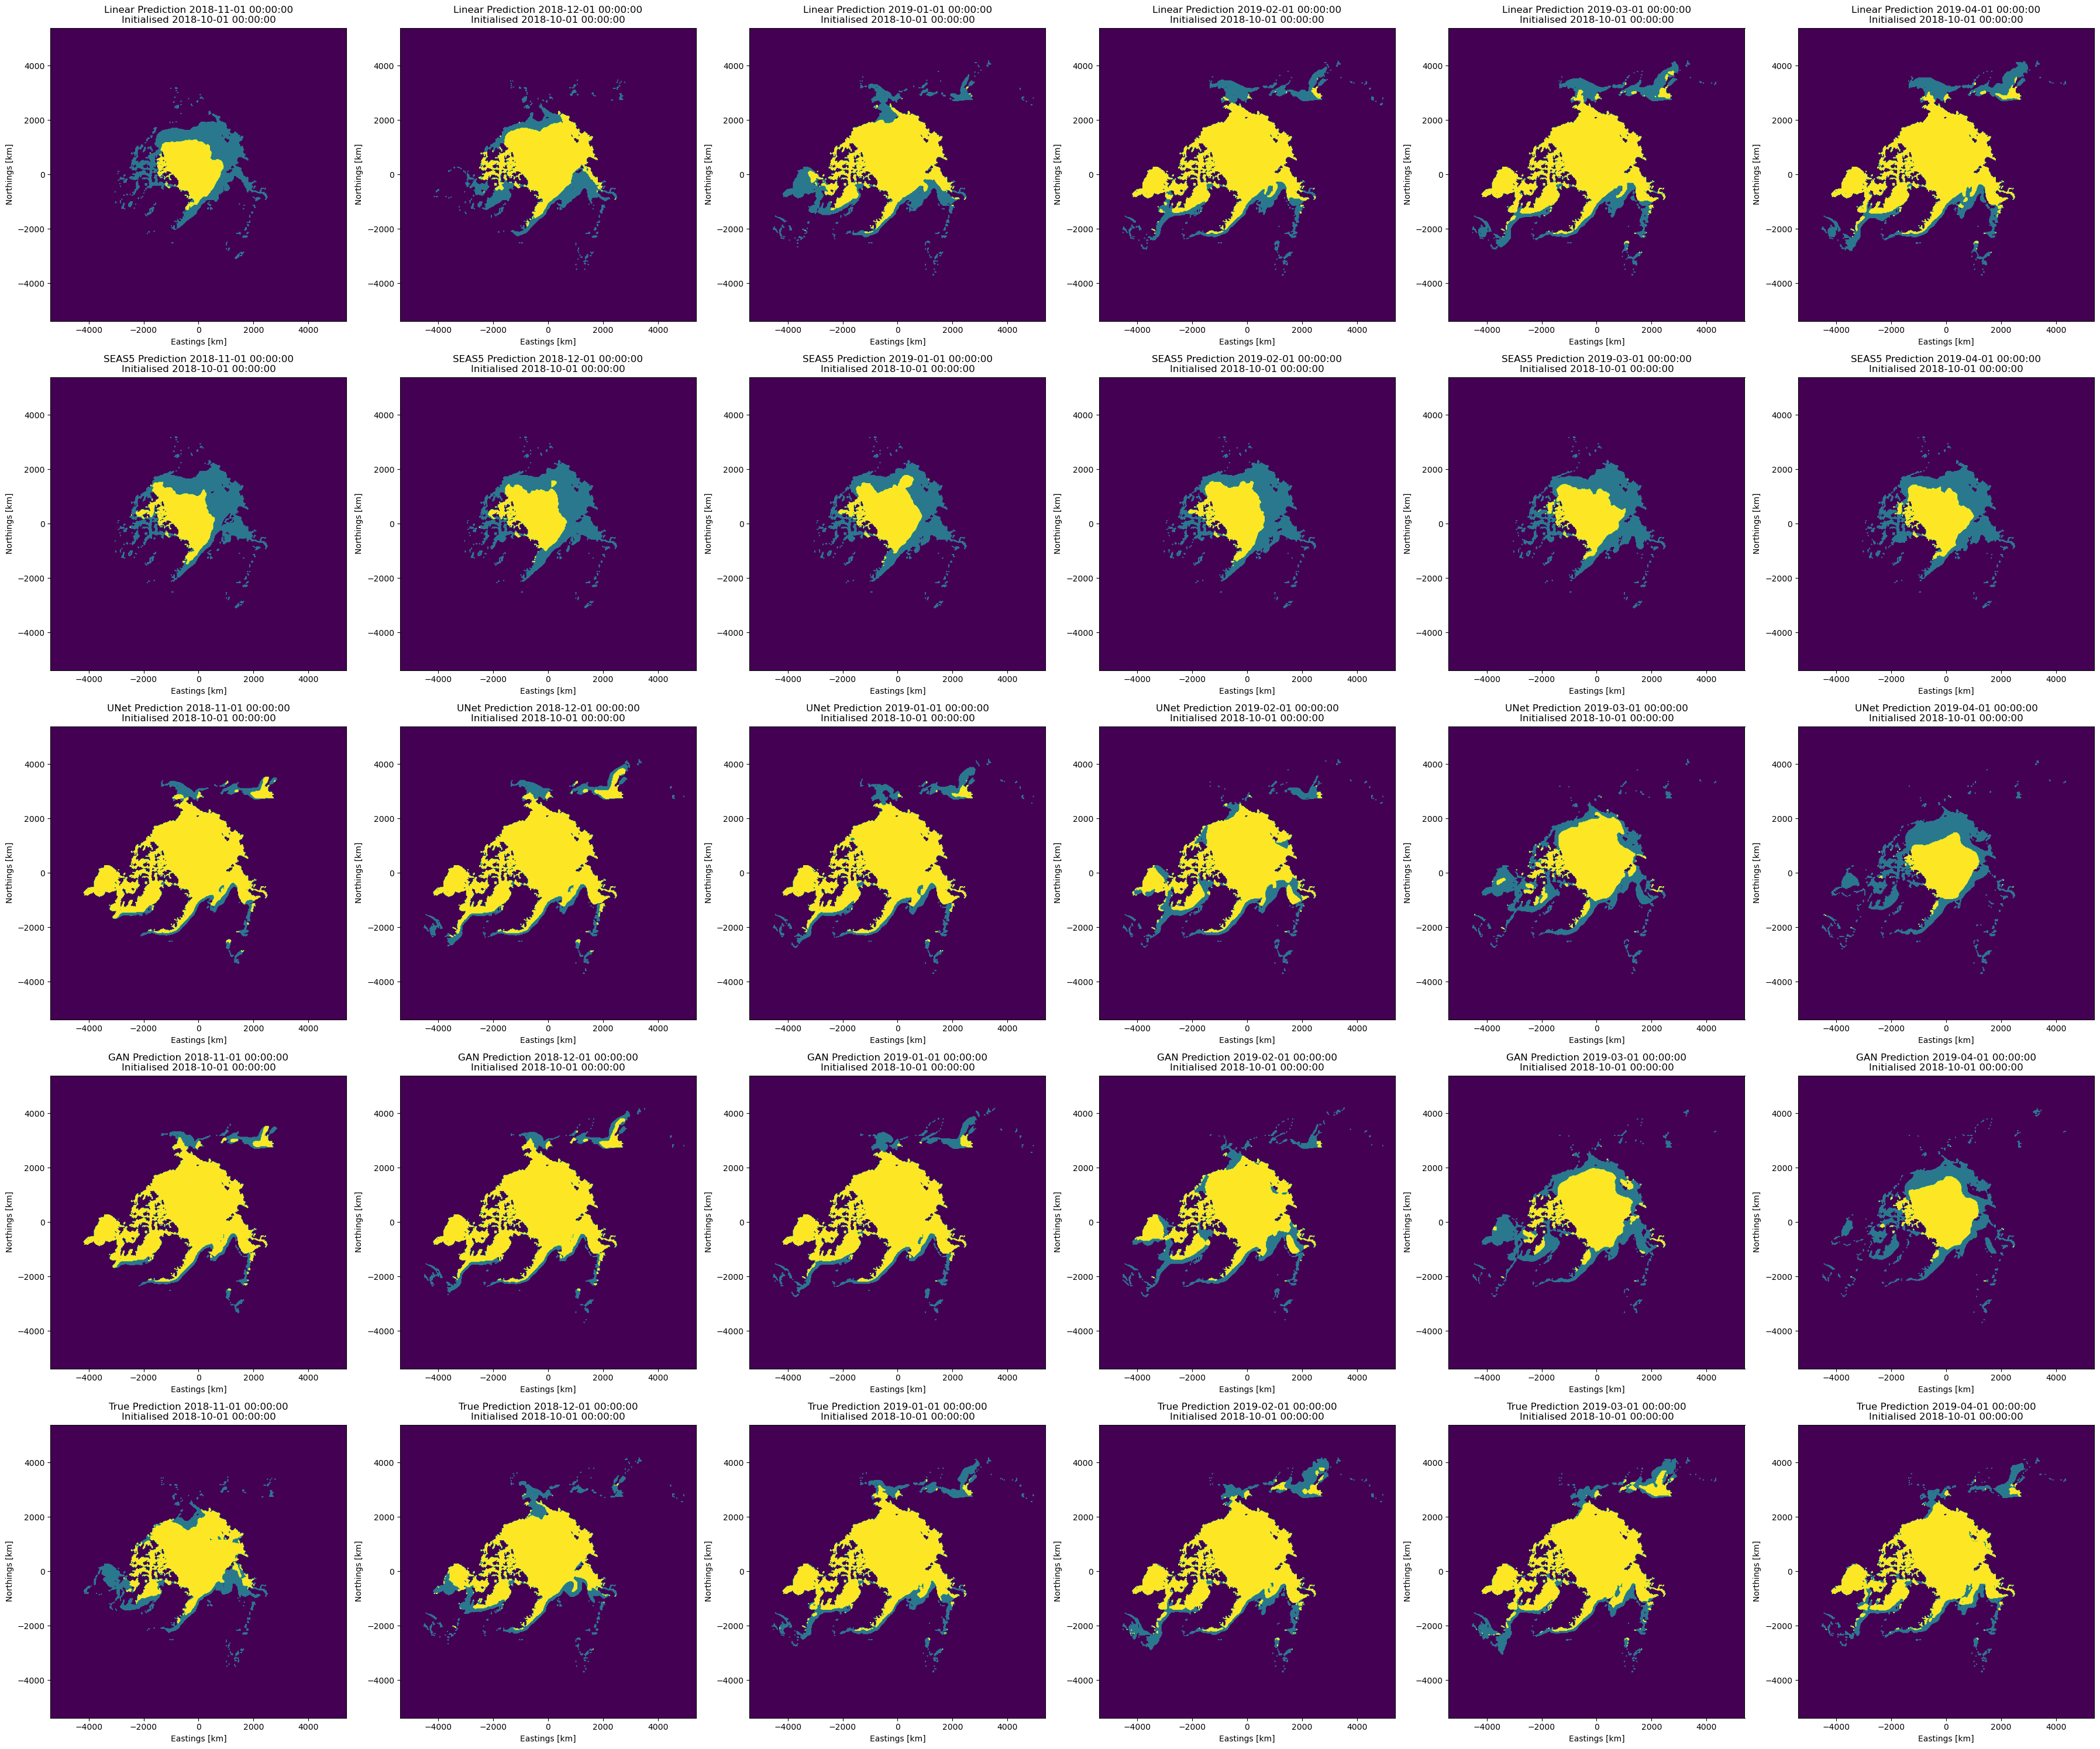

In [90]:
winter = datetime(year=2018, month=10, day=1)
src.visualise_forecast(forecast_dict_with_truth, forecast_mask, winter)

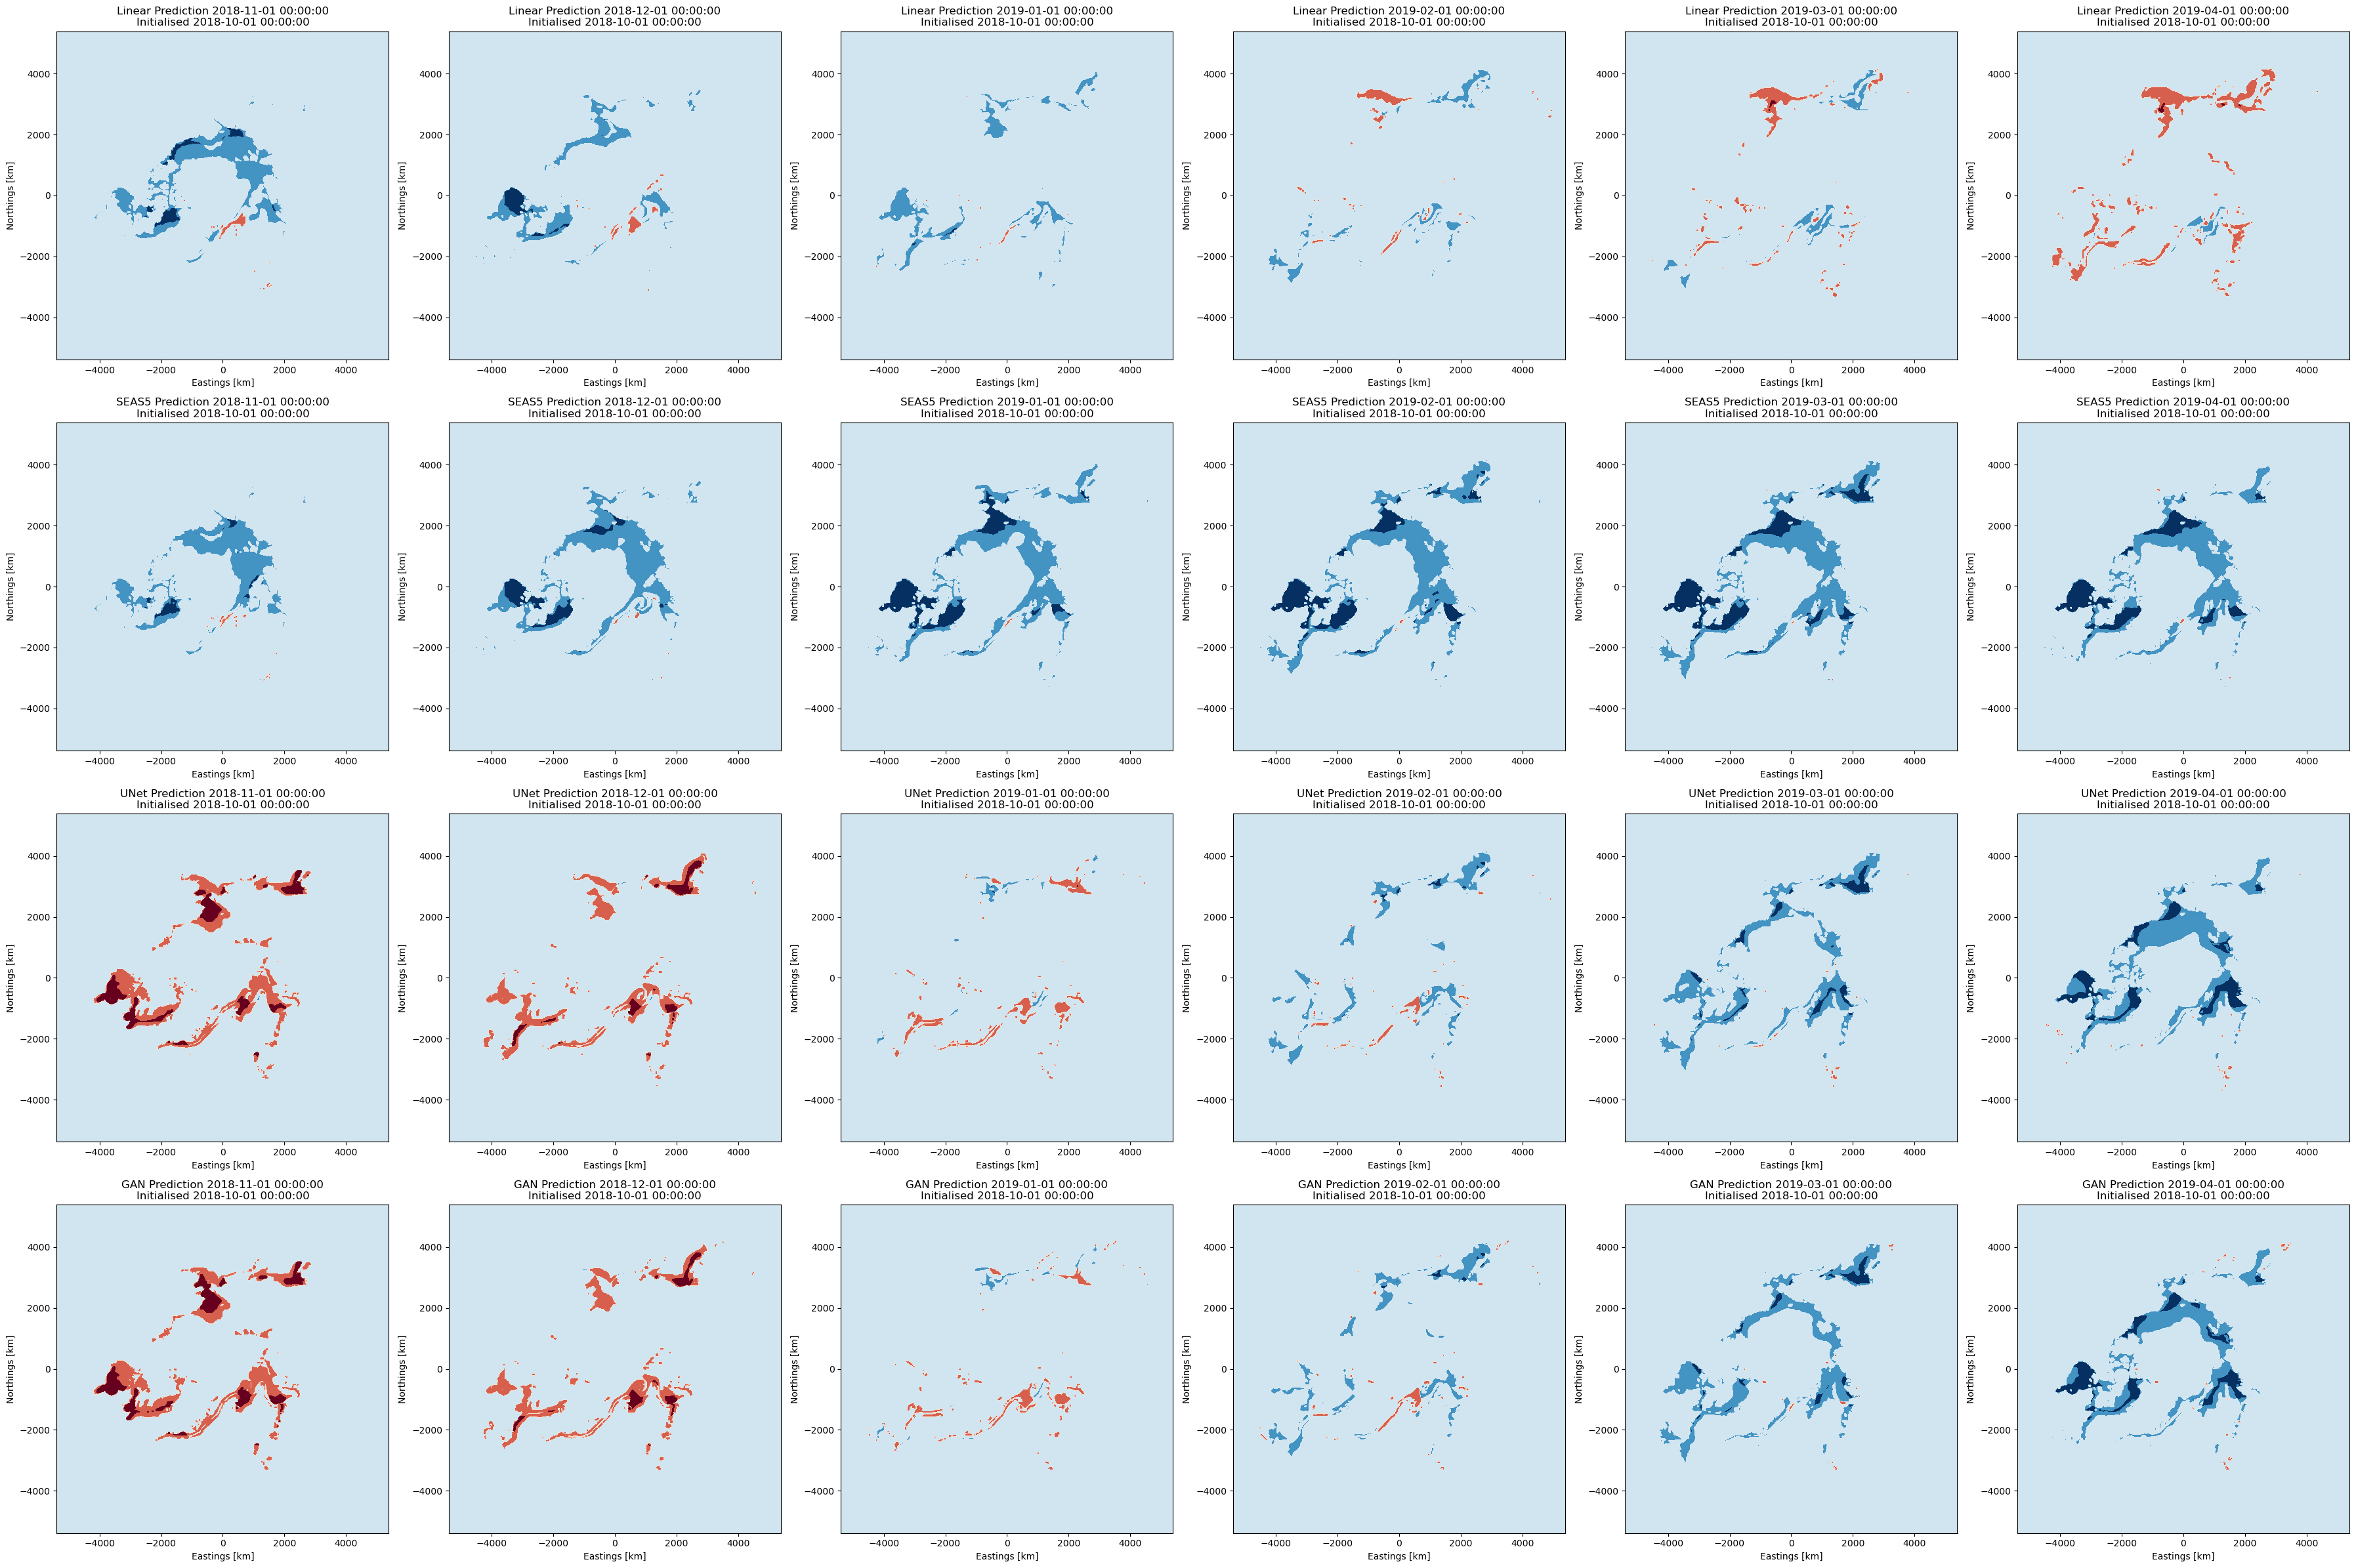

In [147]:
src.visualise_forecast(forecast_dict, forecast_mask, winter, diff=True, true_forecast=true_forecast)

### n. Visualise unmasked forecast
Our linear model inherently incorporates the land mask in its predictions, as pixels over land are not fit with a linear trend.

Similarly, the SEAS5 model inherently incorporates the land mask in its predictions as a dynamical (physics-based) model.

In contrast, neither our UNet nor GAN models incorporate the land mask in their predictions until the very end, when we take an `argmax` over the logit outputs and manually apply a land mask.

This, in turn, may offer an interesting means of interrogating our UNet and GAN models—visualising their predictions without applying the land mask may provide us with a unique perspective into the model's inner workings.

Because our objective in this analysis is to analyse image structure, we'll look at a single GAN sample as opposed to the mean of its ensemble of samples.

In [38]:
dl_forecast_dict = {
    "UNet Unmasked": unet_forecast,
    "GAN Unmasked Member 1": gan_prob_forecast.sel(seed=["0"]),
}

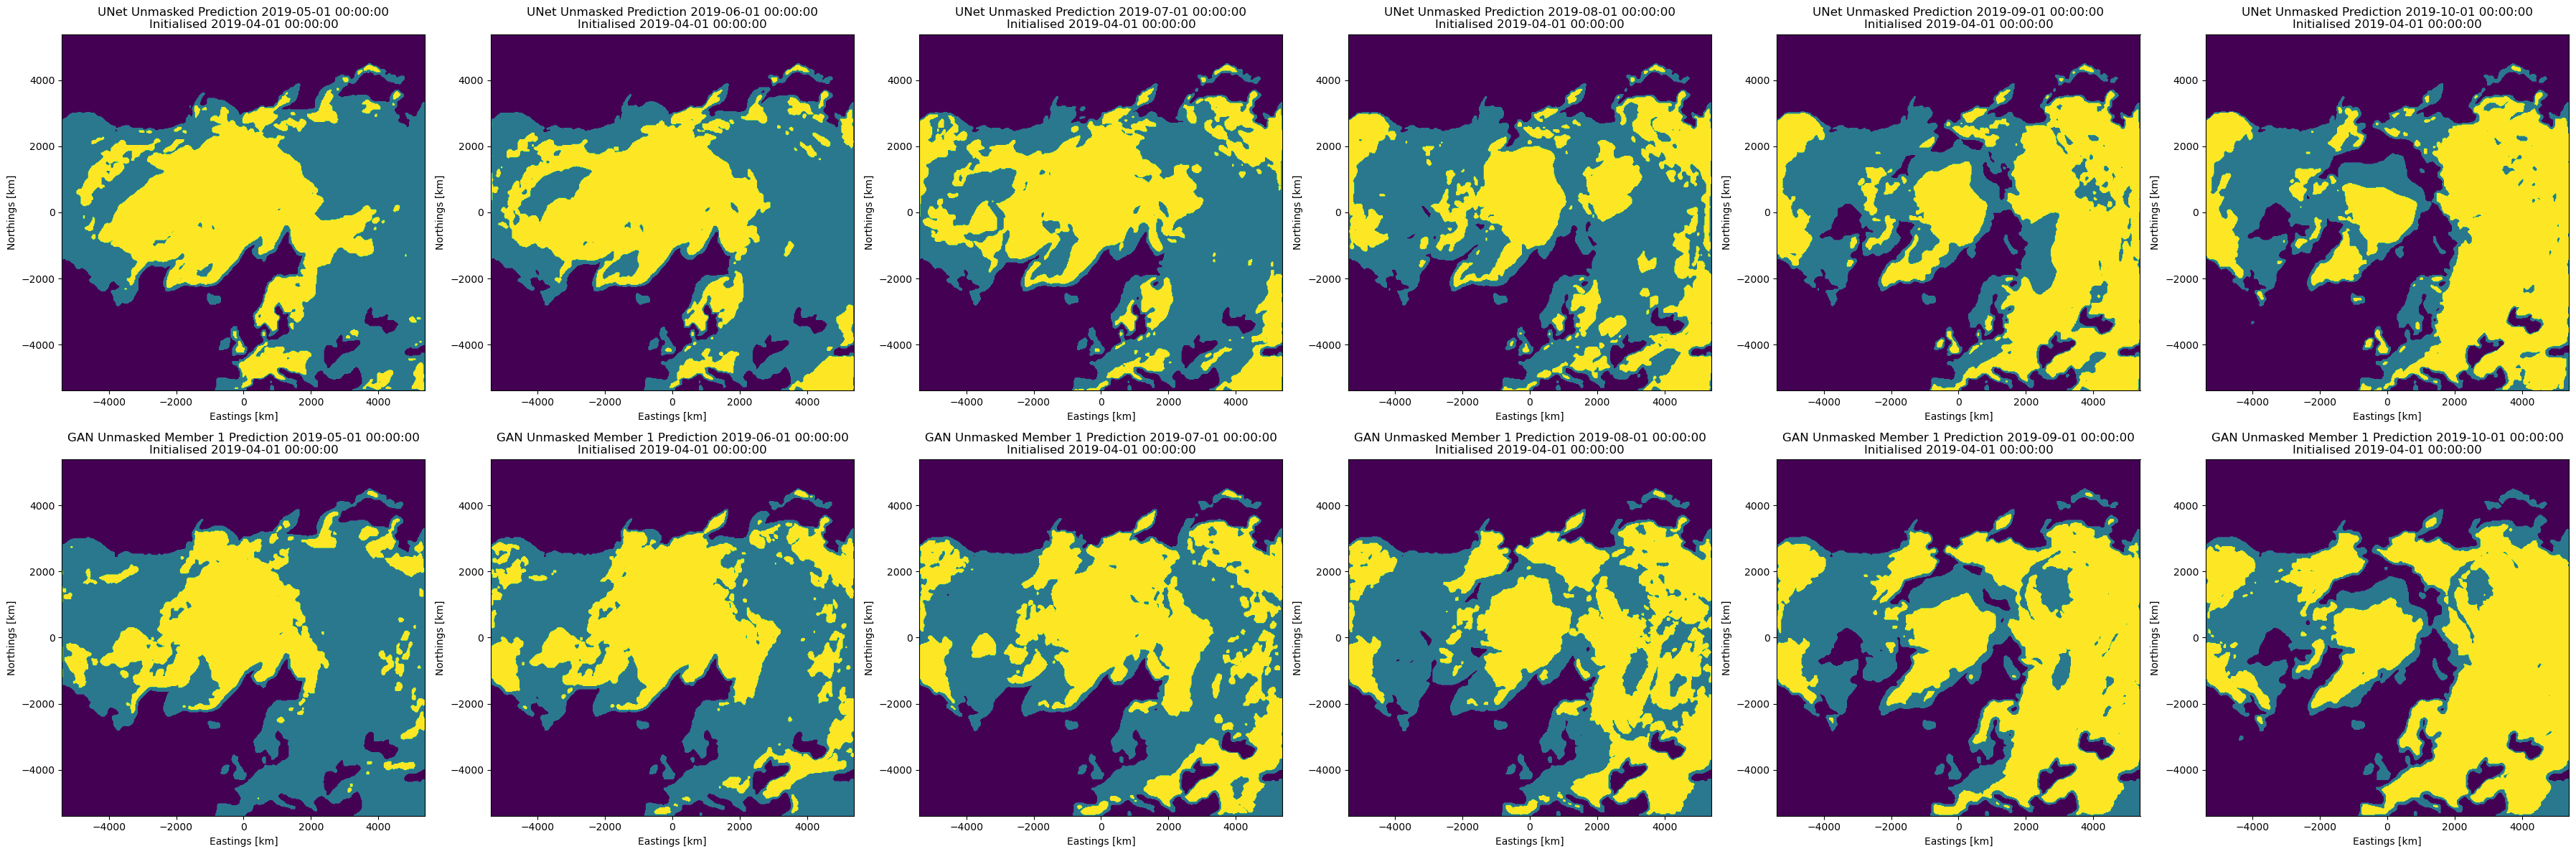

In [39]:
src.visualise_forecast(dl_forecast_dict, xr.ones_like(forecast_mask), summer)

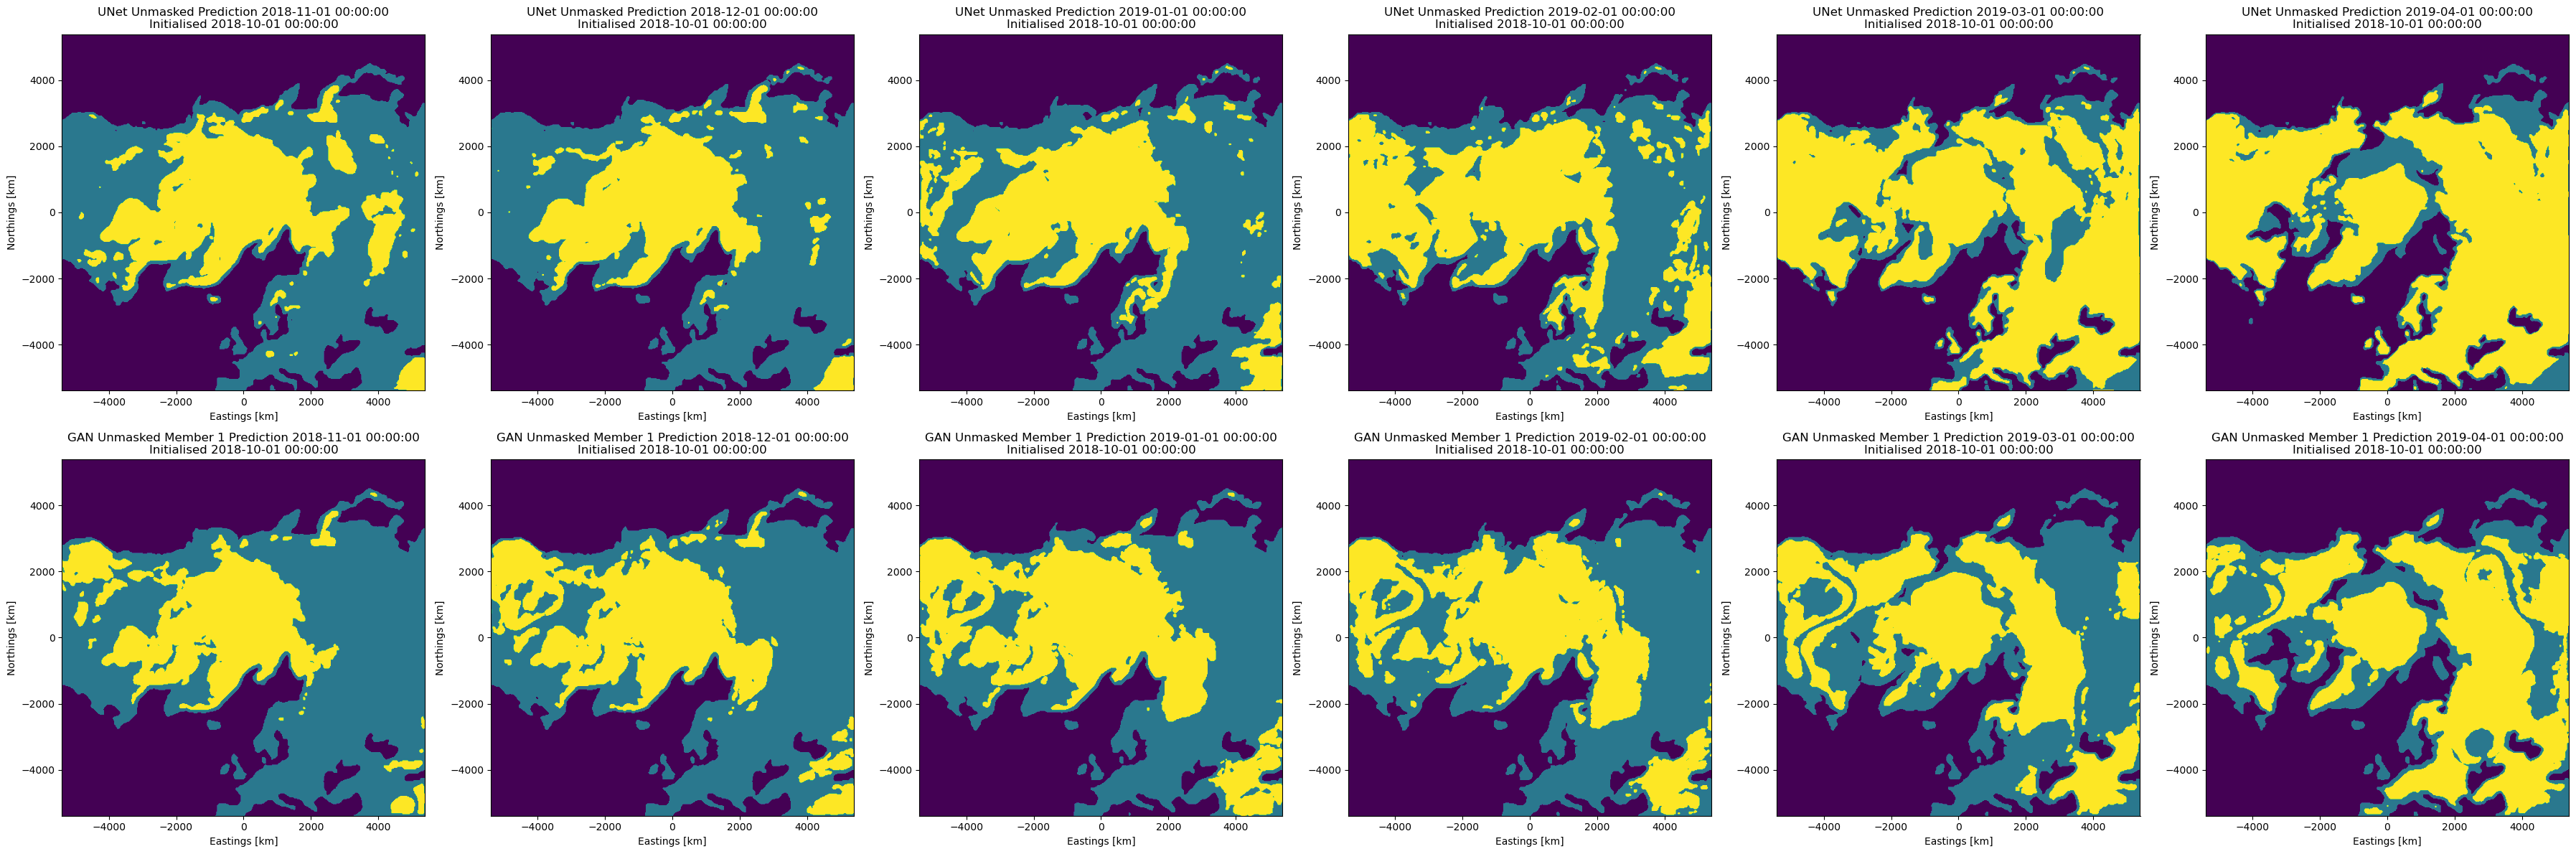

In [40]:
src.visualise_forecast(dl_forecast_dict, xr.ones_like(forecast_mask), winter)

### n. Visualise unmasked GAN ensemble forecast
Recall that the generator of our GAN learns an implicit probability distribution of the data during training by trying to fool the discriminator, allowing us to construct an ensemble forecast at inference-time without needing to train additional models. Building on the previous analysis, let's have a look at the spread of this GAN ensemble. 

In [41]:
gan_std = gan_prob_forecast.isel(seed=range(25))
gan_std = gan_std.reduce(np.std, dim="seed", keepdims=True)  # take std along seed dimension
gan_std = gan_std.reduce(np.sum, dim="ice_class", keepdims=True)  # sum class probablity stds along channel
gan_std

<xarray.DataArray (seed: 1, time: 17, yc: 432, xc: 432, leadtime: 6,
                   ice_class: 1)>
array([[[[[[3.73310558e-02],
           [5.75862080e-03],
           [5.18053677e-03],
           [8.50895140e-03],
           [3.01262102e-04],
           [3.19329761e-02]],

          [[2.35835137e-03],
           [5.02914045e-05],
           [4.06540697e-04],
           [8.51390883e-04],
           [2.86152635e-06],
           [4.07699437e-04]],

          [[2.71793484e-04],
           [4.64782033e-06],
           [7.26975632e-05],
           [1.76491420e-04],
           [2.95262851e-07],
           [1.19148681e-05]],
...
          [[3.78802046e-03],
           [1.60132051e-01],
           [1.11517996e-01],
           [8.46504606e-03],
           [4.80153970e-03],
           [7.82415122e-02]],

          [[5.03813429e-03],
           [1.40724182e-01],
           [6.78787082e-02],
           [1.30656837e-02],
           [3.15131806e-02],
           [1.00989521e-01]],

          [[1.23259500e-02],
           [8.76476914e-02],
           [4.42063510e-02],
           [7.16790482e-02],
           [4.72723655e-02],
           [3.85963731e-02]]]]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2018-02-01 2018-03-01 ... 2019-06-01
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
    lon       (yc, xc) float32 ...
    lat       (yc, xc) float32 ...
  * leadtime  (leadtime) int64 1 2 3 4 5 6
Dimensions without coordinates: seed, ice_class

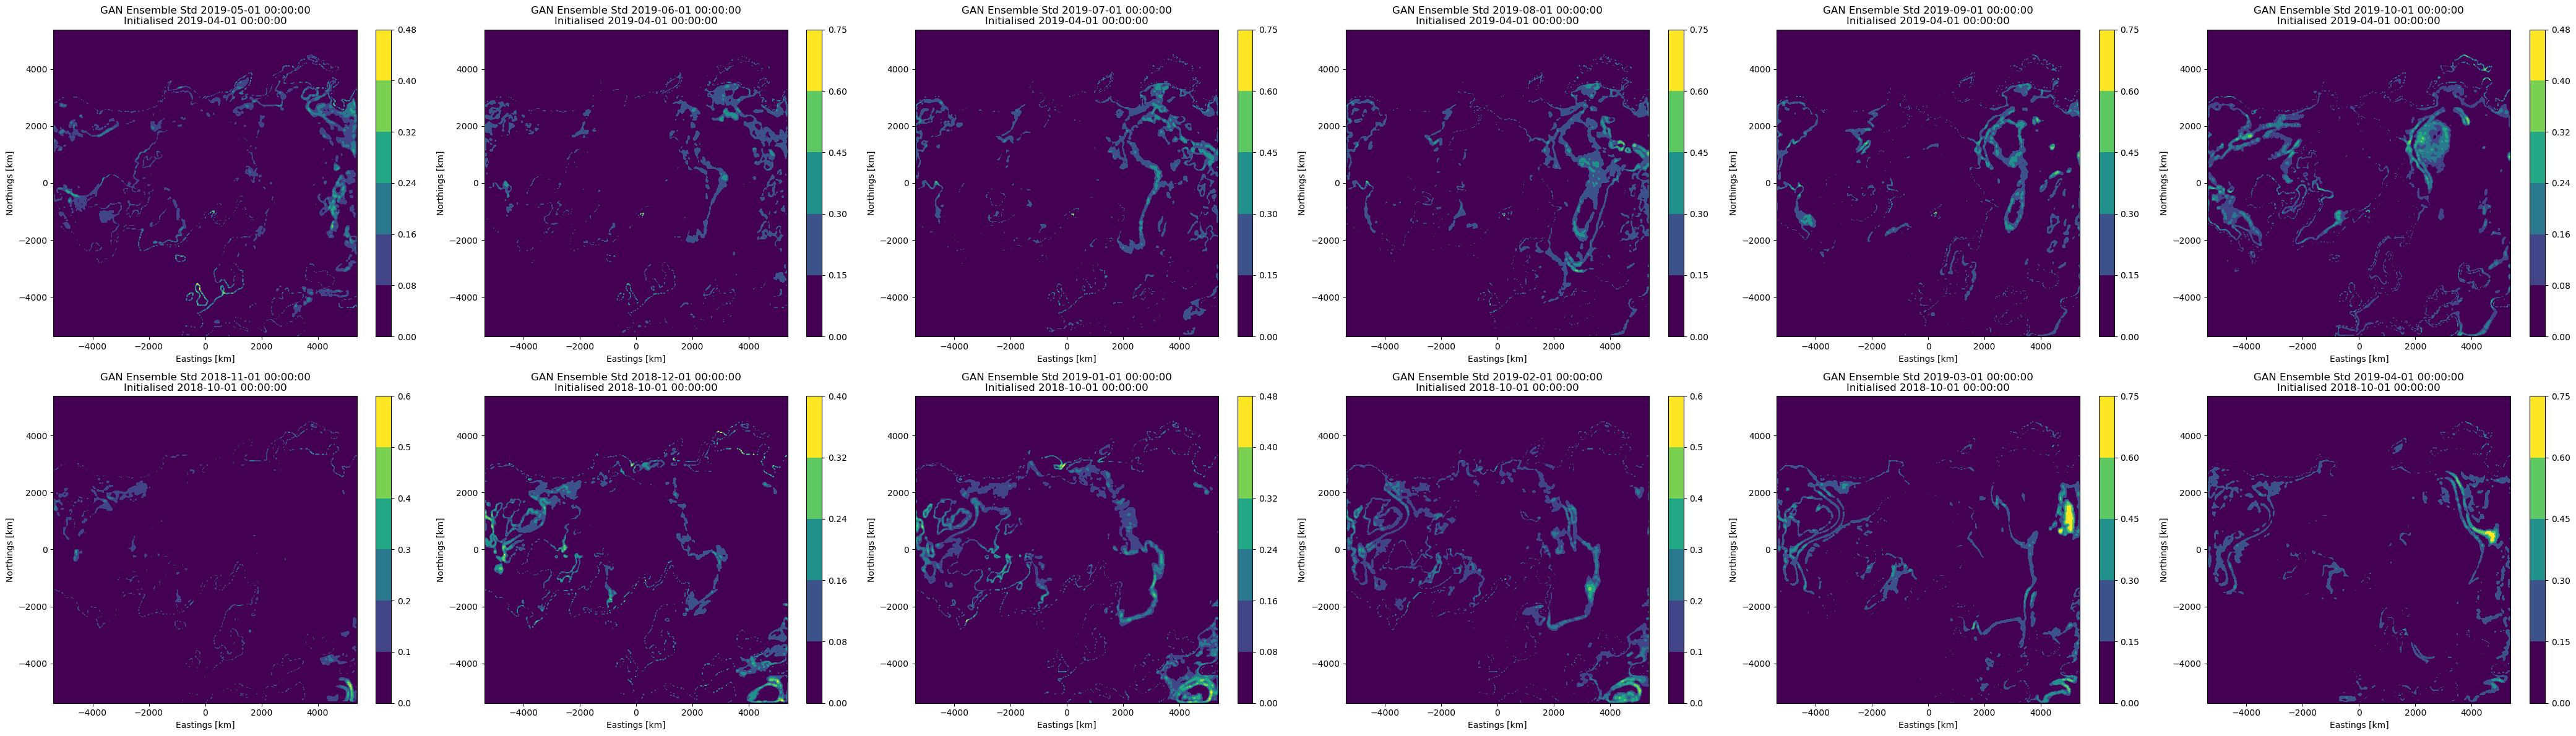

In [42]:
from dateutil.relativedelta import relativedelta
leadtimes = gan_std.leadtime.values
fig, ax = plt.subplots(2, len(leadtimes), figsize=(7*len(leadtimes), 12))
for i, date in enumerate([summer, winter]):
    for leadtime in leadtimes:
        std = gan_std.sel(time=date, leadtime=leadtime).squeeze()
        xr.plot.contourf(std, ax=ax[i, leadtime-1])
        ax[i, leadtime-1].set_title(f"GAN Ensemble Std {date + relativedelta(months=leadtime)}"
                                    f"\nInitialised {date}")
        ax[i, leadtime-1].set_xlabel("Eastings [km]")
        ax[i, leadtime-1].set_ylabel("Northings [km]")
                
plt.tight_layout()
plt.show()

### n. Visualise unmasked probabilities
Because our deep learning models are trained on ternary data, we obtain probabilities of shape 432x432x3 before applying `argmax` to make a class prediction for masking and evaluation.

As such, we may visualise the unmasked probabilities in RGB space for yet another view into the inner workings of our UNet and GAN models.

This view may be particularly insightful, as it is these very probabilities of shape 432x432x3 that we are computing gradients against during the training process.

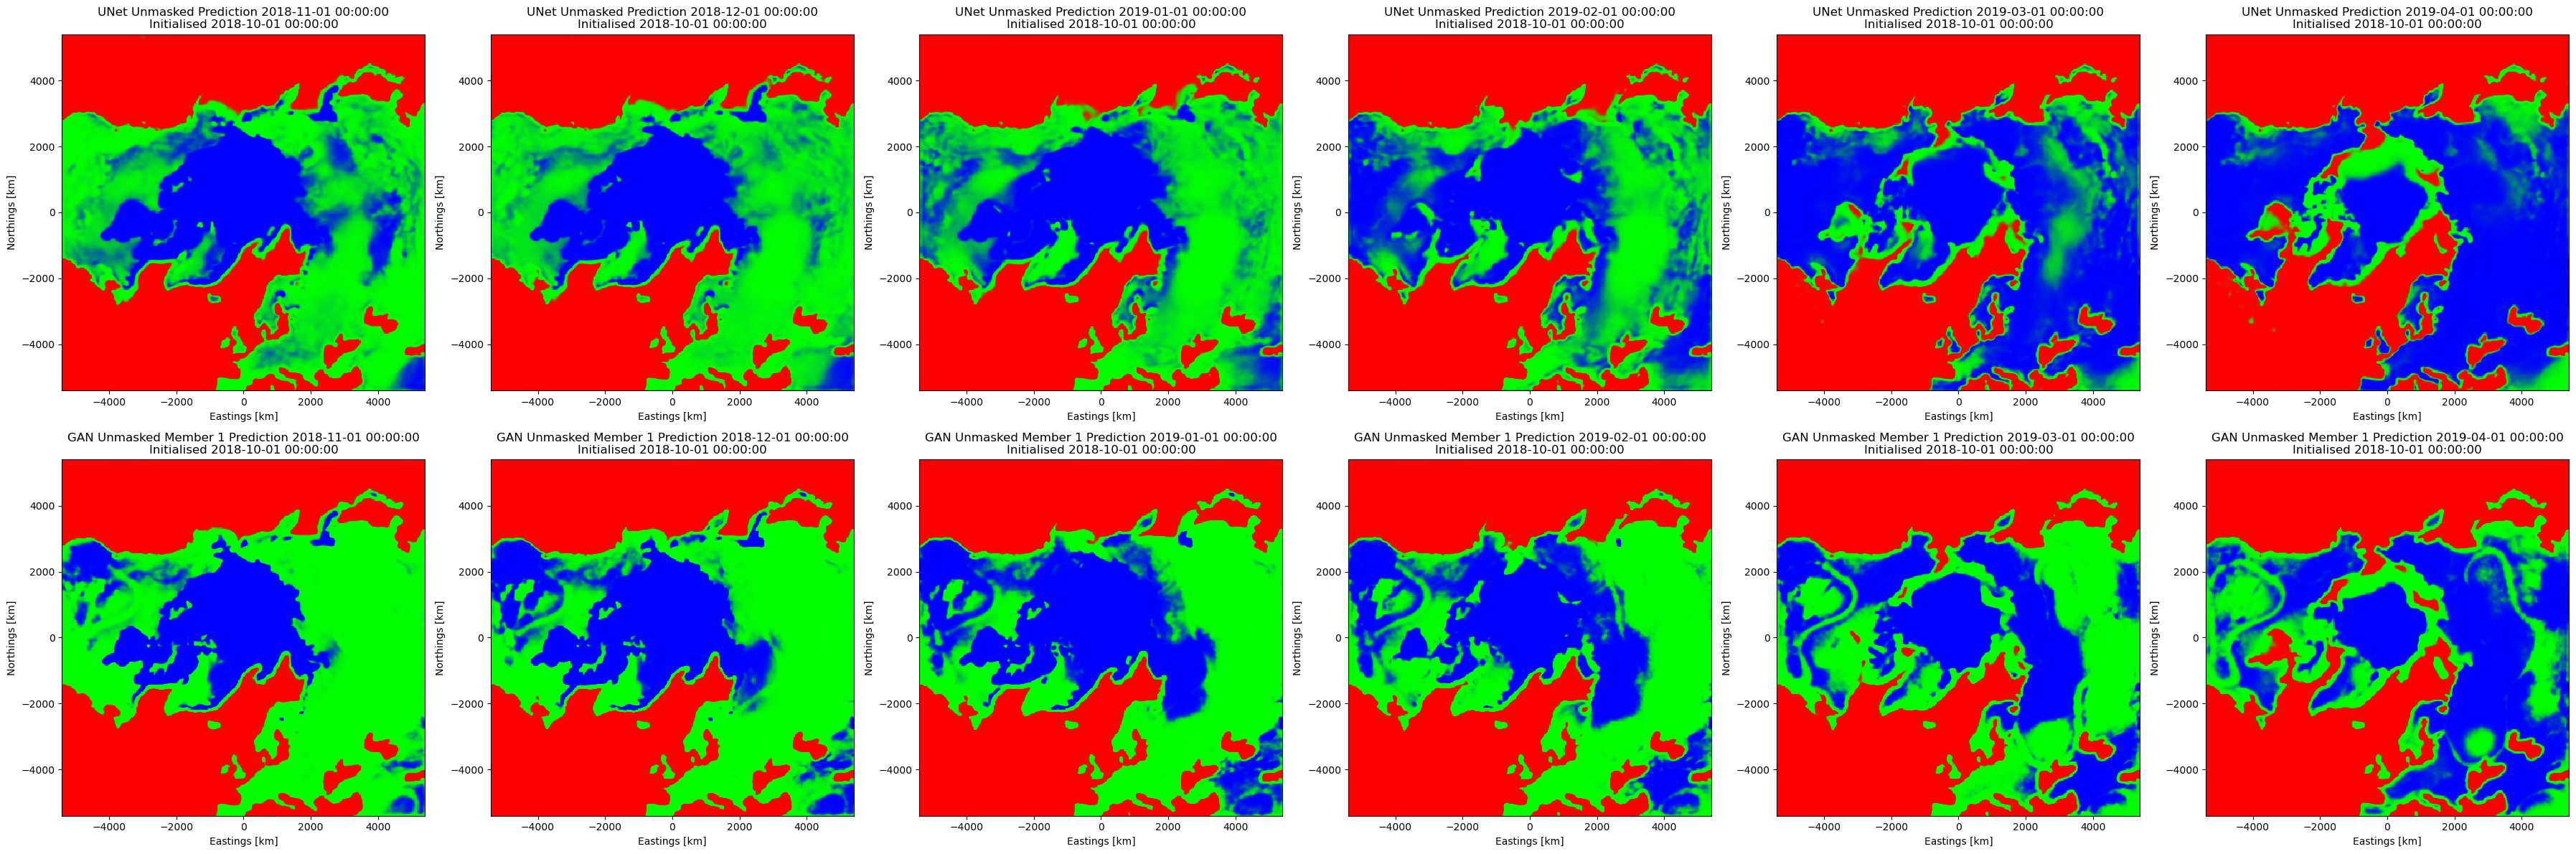

In [43]:
src.visualise_forecast(dl_forecast_dict, xr.ones_like(forecast_mask), winter,
                       diff=False, true_forecast=None, ternerise=False)

### n. Compute SSIM
The structural similarity index provides one metric with which we may quantify image sharpness and structure with respect to a reference image.

Applying this metric to our unmasked probability maps may be telling.

Considering the metric on a single image case study may also be telling.

To compute SSIM (and later PSNR), we'll need a 3-channel target image which preserves the spatial structure of the ground truth 1-channel sea ice observations. Instead of generating a 3-channel ground truth image by one-hot-encoding the sea ice concentration class of each pixel as may seem natural to do, we'll simply repeat the 1-channel sea ice observations three times to generate a 3-channel image. This will preserve the spatial structure and relative pixel magnitudes more faithfully than truncating pixel values to zeros and ones, which creates artificially hard edges.

We'll demonstrate this computation below before computing SSIM.


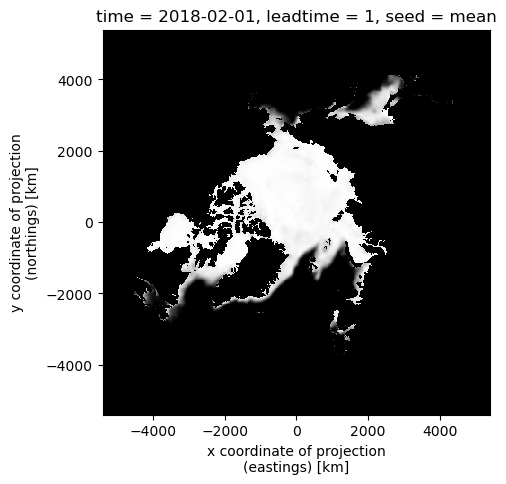

In [58]:
# 3-channel ground truth image against which we'll compare spatial structure
img = true_forecast.isel(time=0, leadtime=0).squeeze()
img2 = gan_forecast.isel(time=0, leadtime=0).squeeze()
img, img2 = xr.broadcast(img, img2)
fig, ax = plt.subplots(figsize=(5, 5))
xr.plot.imshow(img, ax=ax)
plt.show()

In [51]:
ssims = {"Leadtime": [], "UNet": [], "GAN": []}

# compute ssim for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    ssims["Leadtime"].append(leadtime)
    ssims["UNet"].append(src.ssim(unet_forecast, true_forecast, [leadtime]))
    ssims["GAN"].append(src.ssim(gan_forecast, true_forecast, [leadtime]))

# compute ssim for all leadtimes
ssims["Leadtime"].append("All")
leads = list(range(1, 7))
ssims["UNet"].append(src.ssim(unet_forecast, true_forecast, leads))
ssims["GAN"].append(src.ssim(gan_forecast, true_forecast, leads))

# construct dataframe
ssims_df = pd.DataFrame(ssims).set_index("Leadtime")
ssims_df

  0%|          | 0/6 [00:00<?, ?it/s]


KeyError: 'Linear'

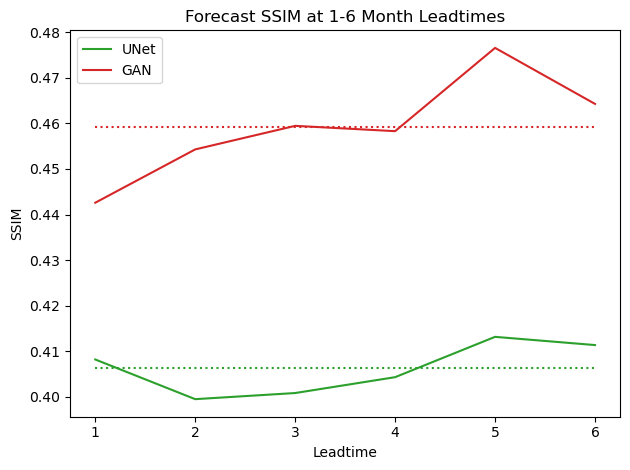

In [54]:
# plot against leadtime
fig, ax = plt.subplots()
sub_cmap = LinearSegmentedColormap.from_list("", [tab10(2), tab10(3)])
ssims_df.drop("All").plot(ax=ax, colormap=sub_cmap)
for i, model in enumerate(ssims_df.columns):
    plt.hlines(ssims_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i+2), linestyles=":")
plt.ylabel("SSIM")
plt.title("Forecast SSIM at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### n. Compute PSNR
The peak-signal-to-noise ratio provides one metric with which we may quantify image sharpness and structure with respect to a reference image.

Applying this metric to our unmasked probability maps may be telling.

Considering the metric on a single image case study may also be telling.


In [52]:
psnrs = {"Leadtime": [], "UNet": [], "GAN": []}

# compute psnr for individual leadtimes
for leadtime in tqdm(range(1, 7)):
    psnrs["Leadtime"].append(leadtime)
    psnrs["UNet"].append(src.psnr(unet_forecast, true_forecast, [leadtime]))
    psnrs["GAN"].append(src.psnr(gan_forecast, true_forecast, [leadtime]))

# compute psnr for all leadtimes
psnrs["Leadtime"].append("All")
leads = list(range(1, 7))
psnrs["UNet"].append(src.psnr(unet_forecast, true_forecast, leads))
psnrs["GAN"].append(src.psnr(gan_forecast, true_forecast, leads))

# construct dataframe
psnrs_df = pd.DataFrame(psnrs).set_index("Leadtime")
psnrs_df

100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


UNet       GAN
Leadtime                    
1         4.989839  4.830072
2         5.095896  4.789172
3         5.120606  4.792364
4         5.103937  4.823379
5         5.057515  4.762201
6         5.035525  4.812117
All       5.067220  4.801551

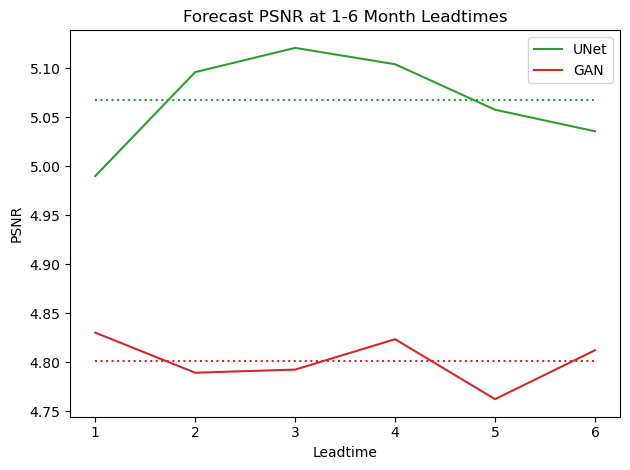

In [55]:
# plot against leadtime
fig, ax = plt.subplots()
sub_cmap = LinearSegmentedColormap.from_list("", [tab10(2), tab10(3)])
psnrs_df.drop("All").plot(ax=ax, colormap=sub_cmap)
for i, model in enumerate(psnrs_df.columns):
    plt.hlines(psnrs_df[model].loc["All"], xmin=0, xmax=5, colors=tab10(i+2), linestyles=":")
plt.ylabel("PSNR")
plt.title("Forecast PSNR at 1-6 Month Leadtimes")
plt.tight_layout()
plt.show()

### n. Compute radially-averaged spectral power density

The [radially-averaged power spectral density (RAPSD) metric](https://pysteps.readthedocs.io/en/stable/generated/pysteps.utils.spectral.rapsd.html) is often used in weather radar analysis to quantify the frequency spectrum of spatial structures. 

We'll use it here to characterise the texture of our unmasked probability maps.

In [61]:

def rapsd_field(field, fft_method=np.fft, return_freq=True, d=1.0, normalize=False, **fft_kwargs):
    """
    From https://github.com/pySTEPS/pysteps/blob/master/pysteps/utils/spectral.py#L100
    Because this is the only function we use from pySTEPS, we copy it to avoid a 200mb install.
    """
    def compute_centred_coord_array(M, N):
        """
        From https://github.com/pySTEPS/pysteps/blob/master/pysteps/utils/arrays.py
        """
        if M % 2 == 1:
            s1 = np.s_[-int(M / 2) : int(M / 2) + 1]
        else:
            s1 = np.s_[-int(M / 2) : int(M / 2)]

        if N % 2 == 1:
            s2 = np.s_[-int(N / 2) : int(N / 2) + 1]
        else:
            s2 = np.s_[-int(N / 2) : int(N / 2)]

        YC, XC = np.ogrid[s1, s2]
        return YC, XC

    if len(field.shape) != 2:
        raise ValueError(
            f"{len(field.shape)} dimensions are found, but the number "
            "of dimensions should be 2"
        )

    if np.sum(np.isnan(field)) > 0:
        raise ValueError("input field should not contain nans")

    m, n = field.shape

    yc, xc = compute_centred_coord_array(m, n)
    r_grid = np.sqrt(xc * xc + yc * yc).round()
    l = max(field.shape[0], field.shape[1])

    if l % 2 == 1:
        r_range = np.arange(0, int(l / 2) + 1)
    else:
        r_range = np.arange(0, int(l / 2))

    if fft_method is not None:
        psd = fft_method.fftshift(fft_method.fft2(field, **fft_kwargs))
        psd = np.abs(psd) ** 2 / psd.size
    else:
        psd = field

    result = []
    for r in r_range:
        mask = r_grid == r
        psd_vals = psd[mask]
        result.append(np.mean(psd_vals))

    result = np.array(result)

    if normalize:
        result /= np.sum(result)

    if return_freq:
        freq = np.fft.fftfreq(l, d=d)
        freq = freq[r_range]
        return result, freq
    else:
        return result


def rapsd(preds: xr.DataArray, target: xr.DataArray, leadtimes_to_evaluate: list):
    """
    Compute radially-averaged power spectral density to evaluate image structure.
    Because this metric analyses holistic image structure, we do not mask it.
    Expects preds to be a 3-channel probability map and target to be a 1-channel SIC map.
    """
    preds_psd = {"no_ice": [], "marginal_ice": [], "full_ice": []}
    target_psd = []
    for time in preds.time:
        for leadtime in leadtimes_to_evaluate:
            for ice_class in ["no_ice", "marginal_ice", "full_ice"]:
                # can only evaluate one 2D image at a time
                p = preds.sel(time=time, leadtime=leadtime, ice_class=ice_class).squeeze()
                p_psd, f = rapsd_field(p)
                preds_psd[ice_class].append(p_psd)
            t = target.sel(time=time, leadtime=leadtime).squeeze()
            t_psd, f = rapsd_field(t)
            target_psd.append(t_psd)

    # make results into np arrays and take mean across forecasts
    for ice_class in ["no_ice", "marginal_ice", "full_ice"]:
        preds_psd[ice_class] = np.array(preds_psd[ice_class]).mean(axis=0)
    target_psd = np.array(target_psd).mean(axis=0)
    f =  np.array(f)

    # f will be the same for all images since all images are the same size
    return preds_psd, target_psd, f

psds = {"UNet": [], "GAN": [], "Truth": []}

# compute psds for individual leadtimes
leadtimes_to_evaluate = list(range(1, 7))
for leadtime in tqdm(leadtimes_to_evaluate):
    preds_psd, target_psd, f = rapsd(unet_forecast, true_forecast, [leadtime])
    psds["UNet"].append(preds_psd)
    preds_psd, target_psd, f = rapsd(unet_forecast, true_forecast, [leadtime])
    psds["GAN"].append(preds_psd)
    psds["Truth"].append(target_psd)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:26<00:00,  4.35s/it]


Text(0.5, 0.98, 'RAPSD by Ice Class and Leadtime')

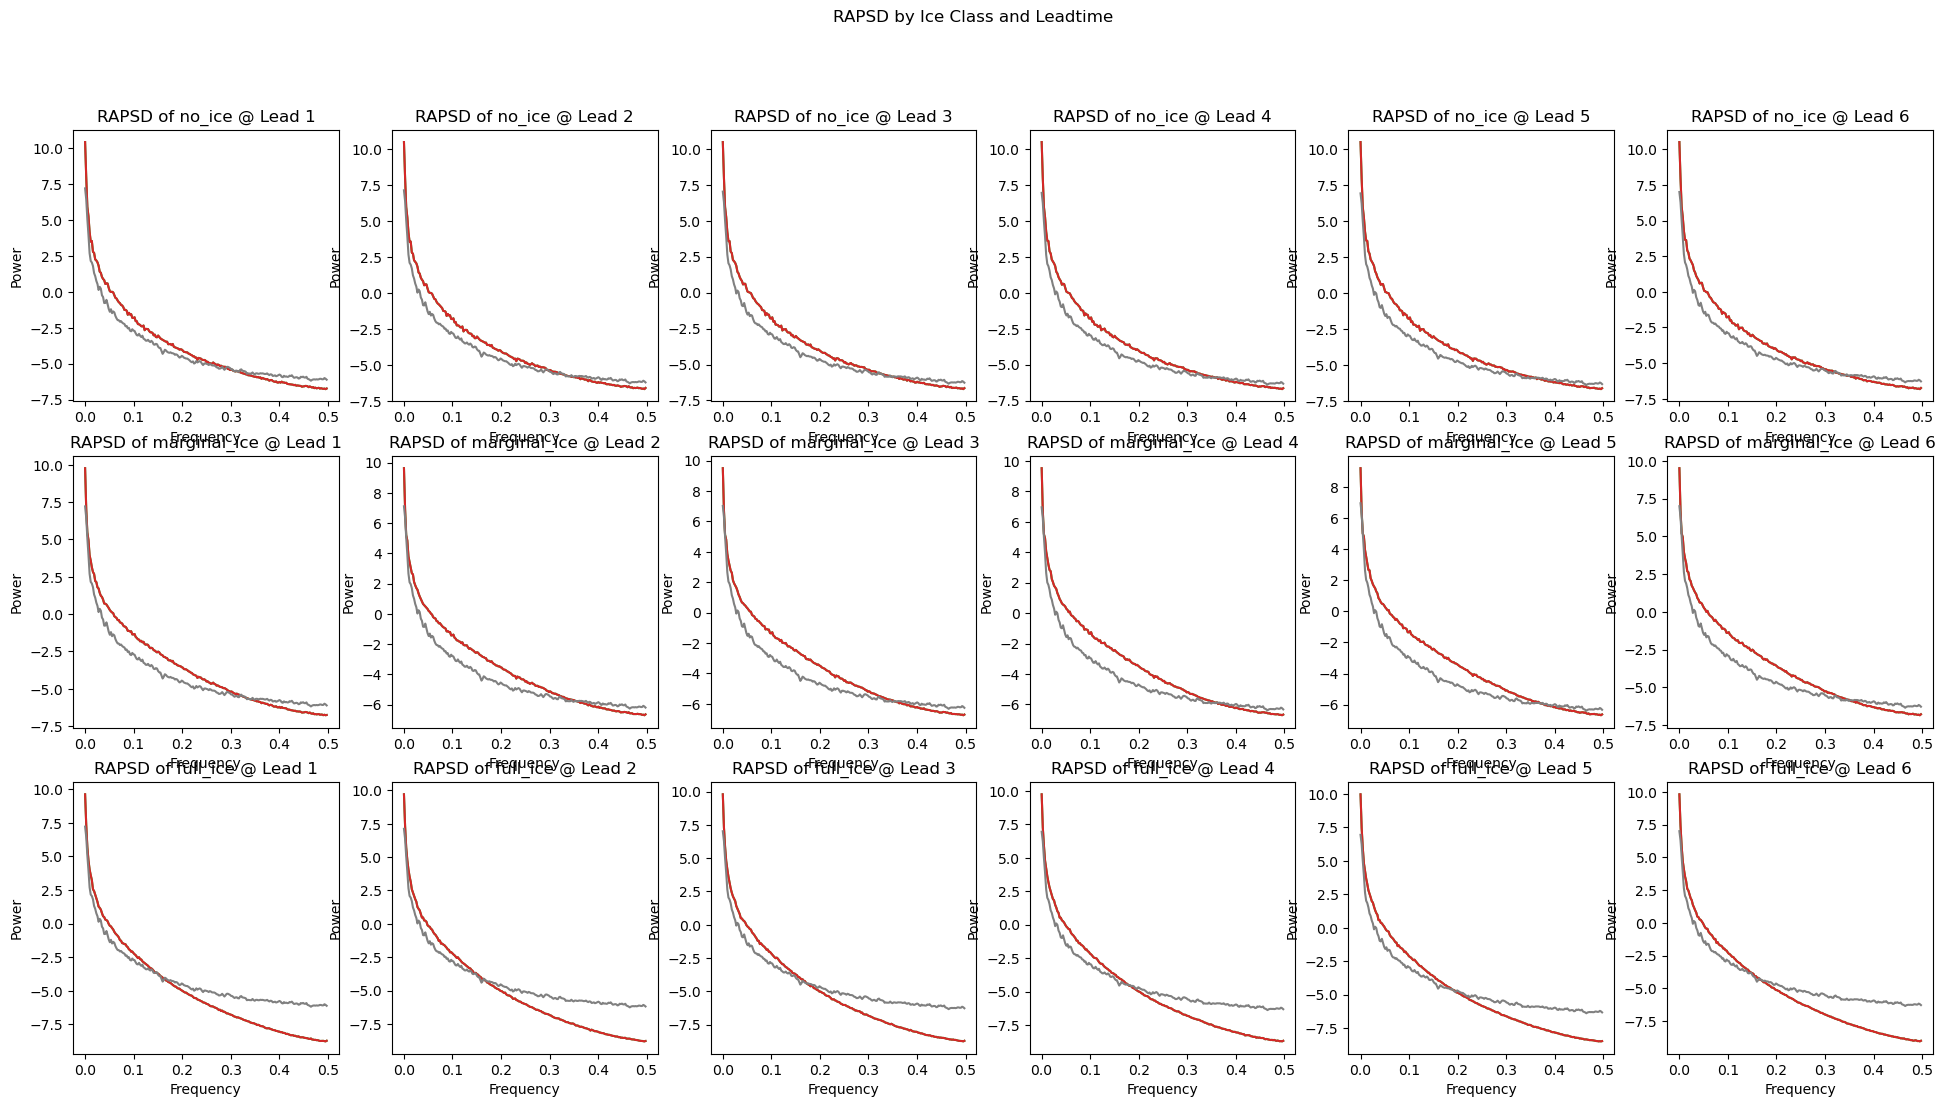

In [64]:
# visualise grid of psd signatures over (ice_class, leadtime)
fig, ax = plt.subplots(3, 6, figsize=(24, 12))
for i, ice_class in enumerate(["no_ice", "marginal_ice", "full_ice"]):
    for leadtime in leadtimes_to_evaluate:
        psd_unet = psds["UNet"][leadtime-1][ice_class]
        ax[i, leadtime-1].plot(f, np.log(psd_unet), label=f"UNet {ice_class}", color=tab10(2))
        psd_gan = psds["GAN"][leadtime-1][ice_class]
        ax[i, leadtime-1].plot(f, np.log(psd_gan), label=f"GAN {ice_class}", color=tab10(3))
        psd_truth = psds["Truth"][leadtime-1]
        ax[i, leadtime-1].plot(f, np.log(psd_truth), label=f"Truth", color="grey")
        ax[i, leadtime-1].set_title(f"RAPSD of {ice_class} @ Lead {leadtime}")
        ax[i, leadtime-1].set_xlabel("Frequency")
        ax[i, leadtime-1].set_ylabel("Power")
plt.suptitle("RAPSD by Ice Class and Leadtime")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# compute psd average over all leadtimes
psnrs["Leadtime"].append("All")
leads = list(range(1, 7))
preds_psd, target_psd, f = src.rapsd(unet_forecast, true_forecast, leads)
psnrs["UNet"].append(preds_psd)
preds_psd, target_psd, f = src.rapsd(gan_forecast, true_forecast, leads)
psnrs["GAN"].append(preds_psd)
psnrs["Truth"].append(target_psd)

# visualise psd signature average over all (ice_class, leadtime)


In [87]:
preds_psd["no_ice"].shape

(216,)

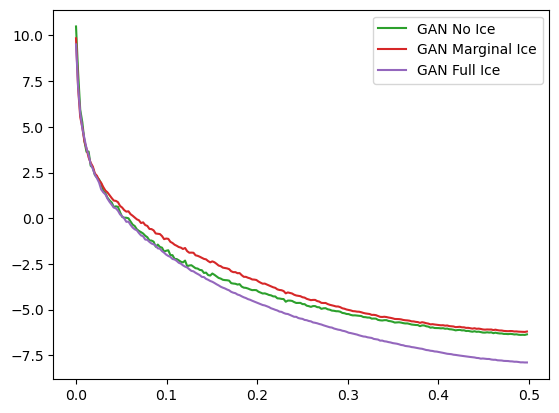

In [90]:
plt.plot(f, np.log(preds_psd["no_ice"]), label="GAN No Ice", color=tab10(2))
plt.plot(f, np.log(preds_psd["marginal_ice"]), label="GAN Marginal Ice", color=tab10(3))
plt.plot(f, np.log(preds_psd["full_ice"]), label="GAN Full Ice", color=tab10(4))
# plt.ylim((0, 1))
plt.legend()
plt.show()